#ƒê√°nh gi√° Hi·ªáu Su·∫•t K·ªãch B·∫£n no-shot prompt cho LLMs annotation 

2025-07-01 16:28:29,622 - INFO - 
========== ƒê√°nh gi√° ƒê·ªìng thu·∫≠n Nh√£n Bloom v√† Ma tr·∫≠n nh·∫ßm l·∫´n ==========
2025-07-01 16:28:29,624 - INFO - ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa ng∆∞·ªùi t·ª´: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv
2025-07-01 16:28:29,632 - INFO - ƒê√£ t·∫£i 220 m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa ng∆∞·ªùi.
2025-07-01 16:28:29,633 - INFO - ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa m√°y t·ª´: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json
2025-07-01 16:28:29,637 - INFO - ƒê√£ t·∫£i 110 m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa m√°y.
2025-07-01 16:28:29,653 - INFO - T√¨m th·∫•y 110 m·ª•c chung ƒë·ªÉ t√≠nh ƒë·ªìng thu·∫≠n nh√£n Bloom.
2025-07-01 16:28:29,656 - INFO - 
--- Ma tr·∫≠n nh·∫ßm l·∫´n cho Nh√£n Bloom ---


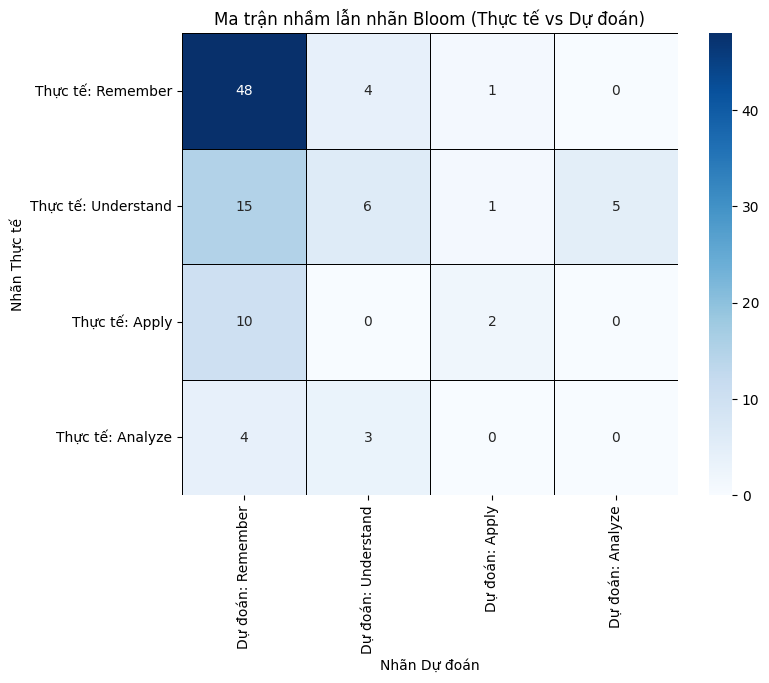

2025-07-01 16:28:29,783 - INFO - 
ƒê·ªô ch√≠nh x√°c (nh√£n Bloom) tr√™n 110 m·ª•c chung: 58.18%
2025-07-01 16:28:29,785 - INFO - Cohen's Kappa (nh√£n Bloom) gi·ªØa Ng∆∞·ªùi v√† M√°y: 0.3059
2025-07-01 16:28:29,786 - INFO - 
--- B√°o c√°o ph√¢n lo·∫°i (Precision, Recall, F1-score theo t·ª´ng nh√£n) ---
2025-07-01 16:28:29,799 - INFO - 
F1-score t·ªïng th·ªÉ (weighted avg) cho Nh√£n Bloom: 0.5051


              precision    recall  f1-score   support

    Remember       0.62      0.86      0.72        56
  Understand       0.46      0.22      0.30        27
       Apply       0.50      0.17      0.25        12
     Analyze       0.00      0.00      0.00         7

   micro avg       0.57      0.55      0.56       102
   macro avg       0.40      0.31      0.32       102
weighted avg       0.52      0.55      0.51       102


K·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom:
  ƒê·ªô ch√≠nh x√°c (Nh√£n Bloom): 58.18%
  Cohen's Kappa (Nh√£n Bloom): 0.3059
  F1-score t·ªïng th·ªÉ (Nh√£n Bloom): 0.5051


In [ ]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report, f1_score
import numpy as np
import seaborn as sns # Import th∆∞ vi·ªán seaborn
import matplotlib.pyplot as plt # Import th∆∞ vi·ªán matplotlib ƒë·ªÉ hi·ªÉn th·ªã bi·ªÉu ƒë·ªì

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def normalize_answer(s: str) -> str:
    """
    Chu·∫©n h√≥a c√¢u tr·∫£ l·ªùi: chuy·ªÉn v·ªÅ ch·ªØ th∆∞·ªùng, lo·∫°i b·ªè d·∫•u c√¢u, lo·∫°i b·ªè kho·∫£ng tr·∫Øng th·ª´a.
    V√≠ d·ª•: "Xin ch√†o, th·∫ø gi·ªõi!" -> "xin chao the gioi"
    """
    def remove_punc(text):
        # Gi·ªØ l·∫°i c√°c k√Ω t·ª± ch·ªØ c√°i, s·ªë v√† kho·∫£ng tr·∫Øng. Lo·∫°i b·ªè t·∫•t c·∫£ c√°c k√Ω t·ª± kh√°c.
        return re.sub(r'[^\w\s]', '', text)

    def lower_and_strip(text):
        return text.lower().strip()

    s = lower_and_strip(s)
    s = remove_punc(s)
    # Thay th·∫ø nhi·ªÅu kho·∫£ng tr·∫Øng th√†nh m·ªôt kho·∫£ng tr·∫Øng duy nh·∫•t
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """
    T√≠nh F1 score d·ª±a tr√™n s·ª± tr√πng l·∫∑p token gi·ªØa c√¢u tr·∫£ l·ªùi d·ª± ƒëo√°n v√† c√¢u tr·∫£ l·ªùi th·∫≠t.
    ƒê√¢y l√† c√°ch t√≠nh F1 score th∆∞·ªùng d√πng trong c√°c b√†i to√°n Question Answering (v√≠ d·ª• SQuAD).
    """
    # Chu·∫©n h√≥a v√† t√°ch token
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát: c·∫£ hai chu·ªói ƒë·ªÅu r·ªóng
    if not prediction_tokens and not ground_truth_tokens:
        return 1.0 # Coi nh∆∞ tr√πng kh·ªõp ho√†n h·∫£o n·∫øu c·∫£ hai ƒë·ªÅu kh√¥ng c√≥ n·ªôi dung
    # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p m·ªôt trong hai chu·ªói r·ªóng
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0 # Kh√¥ng c√≥ s·ª± tr√πng kh·ªõp n·∫øu m·ªôt b√™n r·ªóng

    # ƒê·∫øm s·ªë l·∫ßn xu·∫•t hi·ªán c·ªßa m·ªói token trong c·∫£ hai chu·ªói
    # Counter gi√∫p x·ª≠ l√Ω c√°c t·ª´ l·∫∑p l·∫°i (v√≠ d·ª•: "a a b" v√† "a b b" -> common "a b")
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0.0

    # T√≠nh Precision (ƒê·ªô ch√≠nh x√°c) v√† Recall (ƒê·ªô ph·ªß)
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    
    # Tr√°nh chia cho 0 n·∫øu precision v√† recall ƒë·ªÅu b·∫±ng 0
    if precision + recall == 0:
        return 0.0
    
    # T√≠nh F1 score
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def calculate_average_f1_and_accuracy(ground_truth_path: str, prediction_path: str) -> Optional[Dict[str, float]]:
    """
    T·∫£i d·ªØ li·ªáu t·ª´ hai file (CSV/JSON), t√¨m c√°c c√¢u h·ªèi chung, v√† t√≠nh F1 score trung b√¨nh
    v√† Accuracy (t·ª∑ l·ªá c√°c c√¢u tr·∫£ l·ªùi kh·ªõp ho√†n h·∫£o).

    Args:
        ground_truth_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu "th·∫≠t" (ground truth).
                                 H·ªó tr·ª£ CSV.
        prediction_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu "d·ª± ƒëo√°n" (prediction).
                               H·ªó tr·ª£ CSV ho·∫∑c JSON.

    Returns:
        Optional[Dict[str, float]]: Dictionary ch·ª©a F1 score trung b√¨nh v√† Accuracy,
                                    ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu ground truth t·ª´: {ground_truth_path}")
    try:
        gt_df = pd.read_csv(ground_truth_path, encoding='utf-8')
        gt_df_indexed = gt_df.set_index('question') 
        logger.info(f"ƒê√£ t·∫£i {len(gt_df_indexed)} c·∫∑p Q&A t·ª´ ground truth.")
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file ground truth t·∫°i '{ground_truth_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File ground truth '{ground_truth_path}' ph·∫£i c√≥ c·ªôt 'question' v√† 'answer'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file ground truth '{ground_truth_path}': {e}", exc_info=True)
        return None

    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu d·ª± ƒëo√°n t·ª´: {prediction_path}")
    try:
        if prediction_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(prediction_path, encoding='utf-8')
        elif prediction_path.lower().endswith('.json'):
            with open(prediction_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ª± ƒëo√°n '{prediction_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        pred_df_indexed = pred_df.set_index('question')
        logger.info(f"ƒê√£ t·∫£i {len(pred_df_indexed)} c·∫∑p Q&A t·ª´ d·ªØ li·ªáu d·ª± ƒëo√°n.")

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ª± ƒëo√°n t·∫°i '{prediction_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ª± ƒëo√°n '{prediction_path}' ph·∫£i c√≥ c·ªôt 'question' v√† 'answer' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ª± ƒëo√°n '{prediction_path}': {e}", exc_info=True)
        return None

    f1_scores = []
    perfect_matches = 0
    processed_questions_count = 0

    for q_gt in gt_df_indexed.index:
        if q_gt in pred_df_indexed.index:
            ground_truth_answer = str(gt_df_indexed.loc[q_gt]['answer'])
            prediction_answer = str(pred_df_indexed.loc[q_gt]['answer'])
            
            f1 = compute_f1_score(prediction_answer, ground_truth_answer)
            f1_scores.append(f1)
            processed_questions_count += 1
            
            if f1 == 1.0:
                perfect_matches += 1

    if not f1_scores:
        logger.warning("Kh√¥ng t√¨m th·∫•y c√¢u h·ªèi chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu. Kh√¥ng th·ªÉ t√≠nh F1 score ho·∫∑c Accuracy.")
        return {'average_f1': 0.0, 'accuracy': 0.0}

    logger.info(f"T√¨m th·∫•y {processed_questions_count} c√¢u h·ªèi chung ƒë·ªÉ t√≠nh F1 score v√† Accuracy.")

    average_f1 = sum(f1_scores) / len(f1_scores)
    accuracy = (perfect_matches / processed_questions_count) * 100 if processed_questions_count > 0 else 0.0
    
    logger.info(f"F1 Score trung b√¨nh tr√™n {processed_questions_count} c√¢u h·ªèi chung: {average_f1:.4f}")
    logger.info(f"Accuracy (kh·ªõp ho√†n h·∫£o) tr√™n {processed_questions_count} c√¢u h·ªèi chung: {accuracy:.2f}%")

    return {'average_f1': average_f1, 'accuracy': accuracy}

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip() # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p kh√¥ng ph·∫£i chu·ªói (v√≠ d·ª• NaN)

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip() # Tr·∫£ v·ªÅ nguy√™n b·∫£n n·∫øu kh√¥ng kh·ªõp (ho·∫∑c r·ªóng n·∫øu kh√¥ng c√≥ g√¨)


def evaluate_bloom_labels(human_labeled_path: str, llm_labeled_path: str,
                          id_column: str = 'question', 
                          human_bloom_label_column: str = 'bloom', # T√™n c·ªôt nh√£n Bloom cho file c·ªßa ng∆∞·ªùi
                          llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]: # T√™n c·ªôt nh√£n Bloom cho file c·ªßa m√°y
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom
    v√† in ra Confusion Matrix, Accuracy, v√† Cohen's Kappa.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c (v√≠ d·ª•: 'question').
                         C·ªôt n√†y s·∫Ω ƒë∆∞·ª£c d√πng ƒë·ªÉ kh·ªõp c√°c m·ª•c gi·ªØa hai file.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a c√°c metric v√† confusion matrix,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa ng∆∞·ªùi t·ª´: {human_labeled_path}")
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        logger.info(f"ƒê√£ t·∫£i {len(human_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa ng∆∞·ªùi.")
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa m√°y t·ª´: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        logger.info(f"ƒê√£ t·∫£i {len(llm_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa m√°y.")

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    # L·∫∑p qua c√°c m·ª•c trong d·ªØ li·ªáu c·ªßa ng∆∞·ªùi v√† t√¨m c√°c m·ª•c chung v·ªõi d·ªØ li·ªáu c·ªßa m√°y
    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                # L·∫•y nh√£n c·ªßa ng∆∞·ªùi (t·ª´ CSV, c·ªôt 'bloom')
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw) # ƒê·∫£m b·∫£o chu·∫©n h√≥a n·∫øu c·∫ßn

                # L·∫•y nh√£n c·ªßa m√°y (t·ª´ JSON, c·ªôt 'bloom_label')
                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw) # Tr√≠ch xu·∫•t ch·ªâ c·∫•p ƒë·ªô Bloom

                # B·ªè qua c√°c nh√£n r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t
                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    logger.info(f"T√¨m th·∫•y {common_items_count} m·ª•c chung ƒë·ªÉ t√≠nh ƒë·ªìng thu·∫≠n nh√£n Bloom.")

    # ƒê·ªãnh nghƒ©a c√°c nh√£n Bloom theo th·ª© t·ª± mong mu·ªën
    # ƒê·∫£m b·∫£o c√°c nh√£n n√†y kh·ªõp ch√≠nh x√°c v·ªõi c√°c nh√£n trong d·ªØ li·ªáu c·ªßa b·∫°n (v√≠ d·ª•: vi·∫øt hoa/th∆∞·ªùng)
    # N·∫øu c√≥ c√°c nh√£n kh√°c ngo√†i 4 nh√£n n√†y, ch√∫ng s·∫Ω kh√¥ng ƒë∆∞·ª£c bao g·ªìm trong ma tr·∫≠n n·∫øu b·∫°n ch·ªâ ƒë·ªãnh labels
    # N·∫øu b·∫°n mu·ªën t·ª± ƒë·ªông ph√°t hi·ªán t·∫•t c·∫£ c√°c nh√£n, h√£y d√πng:
    # all_labels = sorted(list(set(true_labels + predicted_labels)))
    # Tuy nhi√™n, vi·ªác ƒë·ªãnh nghƒ©a r√µ r√†ng gi√∫p ƒë·∫£m b·∫£o th·ª© t·ª± v√† bao g·ªìm c√°c nh√£n c√≥ th·ªÉ kh√¥ng xu·∫•t hi·ªán trong t·∫≠p con d·ªØ li·ªáu n√†y.
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze']

    # 1. T√≠nh Confusion Matrix
    # cm[i, j] l√† s·ªë l∆∞·ª£ng m·∫´u th·ª±c t·∫ø thu·ªôc l·ªõp i ƒë∆∞·ª£c d·ª± ƒëo√°n l√† l·ªõp j
    cm = confusion_matrix(true_labels, predicted_labels, labels=bloom_categories)
    cm_df = pd.DataFrame(cm, index=[f'Th·ª±c t·∫ø: {l}' for l in bloom_categories], columns=[f'D·ª± ƒëo√°n: {l}' for l in bloom_categories])
    
    logger.info("\n--- Ma tr·∫≠n nh·∫ßm l·∫´n cho Nh√£n Bloom ---")
    # Thay v√¨ print(cm_df), ch√∫ng ta s·∫Ω v·∫Ω heatmap
    plt.figure(figsize=(8, 6)) # K√≠ch th∆∞·ªõc bi·ªÉu ƒë·ªì
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, linecolor='black')
    plt.title('Ma tr·∫≠n nh·∫ßm l·∫´n nh√£n Bloom (Th·ª±c t·∫ø vs D·ª± ƒëo√°n)')
    plt.xlabel('Nh√£n D·ª± ƒëo√°n')
    plt.ylabel('Nh√£n Th·ª±c t·∫ø')
    plt.show() # Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì

    # 2. T√≠nh Accuracy
    acc = accuracy_score(true_labels, predicted_labels) * 100
    logger.info(f"\nƒê·ªô ch√≠nh x√°c (nh√£n Bloom) tr√™n {common_items_count} m·ª•c chung: {acc:.2f}%")

    # 3. T√≠nh Cohen's Kappa (th√≠ch h·ª£p cho 2 ng∆∞·ªùi ƒë√°nh gi√°)
    kappa = cohen_kappa_score(true_labels, predicted_labels)
    logger.info(f"Cohen's Kappa (nh√£n Bloom) gi·ªØa Ng∆∞·ªùi v√† M√°y: {kappa:.4f}")

    # 4. In b√°o c√°o ph√¢n lo·∫°i chi ti·∫øt h∆°n (Precision, Recall, F1-score cho t·ª´ng l·ªõp)
    logger.info("\n--- B√°o c√°o ph√¢n lo·∫°i (Precision, Recall, F1-score theo t·ª´ng nh√£n) ---")
    # zero_division=0 ƒë·ªÉ tr√°nh c·∫£nh b√°o/l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o
    report_dict = classification_report(true_labels, predicted_labels, labels=bloom_categories, output_dict=True, zero_division=0)
    print(classification_report(true_labels, predicted_labels, labels=bloom_categories, zero_division=0)) # In b√°o c√°o d·∫°ng b·∫£ng

    # L·∫•y F1-score t·ªïng th·ªÉ (weighted average)
    overall_f1_bloom = report_dict['weighted avg']['f1-score']
    logger.info(f"\nF1-score t·ªïng th·ªÉ (weighted avg) cho Nh√£n Bloom: {overall_f1_bloom:.4f}")

    return {
        'confusion_matrix': cm_df,
        'accuracy_bloom': acc,
        'cohen_kappa': kappa,
        'f1_score_bloom': overall_f1_bloom # Th√™m F1-score t·ªïng th·ªÉ v√†o k·∫øt qu·∫£ tr·∫£ v·ªÅ
    }

# --- Ch·∫°y ch∆∞∆°ng tr√¨nh ---
if __name__ == "__main__":
    # --- ƒê√°nh gi√° nh√£n Bloom v√† Confusion Matrix ---
    # C√°c file n√†y c≈©ng ch·ª©a c·ªôt 'bloom_label' ho·∫∑c 'bloom'
    human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" # ƒê∆∞·ªùng d·∫´n ƒë·∫øn file nh√£n Bloom c·ªßa ng∆∞·ªùi
    llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json" # ƒê∆∞·ªùng d·∫´n ƒë·∫øn file nh√£n Bloom c·ªßa m√°y

    # ƒê·∫£m b·∫£o c√°c t√™n c·ªôt n√†y kh·ªõp v·ªõi t√™n c·ªôt trong file c·ªßa b·∫°n
    ITEM_ID_COLUMN = 'question' # C·ªôt ID ƒë·ªÉ kh·ªõp c√°c m·ª•c
    HUMAN_BLOOM_LABEL_COLUMN = 'bloom' # T√™n c·ªôt nh√£n Bloom trong file CSV c·ªßa ng∆∞·ªùi
    LLM_BLOOM_LABEL_COLUMN = 'bloom_label' # T√™n c·ªôt nh√£n Bloom trong file JSON c·ªßa m√°y

    logger.info("\n========== ƒê√°nh gi√° ƒê·ªìng thu·∫≠n Nh√£n Bloom v√† Ma tr·∫≠n nh·∫ßm l·∫´n ==========")
    bloom_results = evaluate_bloom_labels(
        human_labeled_path=human_bloom_path,
        llm_labeled_path=llm_bloom_path,
        id_column=ITEM_ID_COLUMN,
        human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
        llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
    )

    if bloom_results:
        print(f"\nK·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom:")
        print(f"  ƒê·ªô ch√≠nh x√°c (Nh√£n Bloom): {bloom_results['accuracy_bloom']:.2f}%")
        print(f"  Cohen's Kappa (Nh√£n Bloom): {bloom_results['cohen_kappa']:.4f}")
        print(f"  F1-score t·ªïng th·ªÉ (Nh√£n Bloom): {bloom_results['f1_score_bloom']:.4f}")
        # Ma tr·∫≠n nh·∫ßm l·∫´n v√† b√°o c√°o ph√¢n lo·∫°i ƒë√£ ƒë∆∞·ª£c in tr·ª±c ti·∫øp trong h√†m


#ƒê√°nh gi√° Hi·ªáu Su·∫•t K·ªãch B·∫£n few-shot prompt cho LLMs annotation 

2025-07-01 16:32:09,806 - INFO - 
========== ƒê√°nh gi√° ƒê·ªìng thu·∫≠n Nh√£n Bloom v√† Ma tr·∫≠n nh·∫ßm l·∫´n cho LLM Few-Shot ==========
2025-07-01 16:32:09,807 - INFO - ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa ng∆∞·ªùi t·ª´: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv
2025-07-01 16:32:09,812 - INFO - ƒê√£ t·∫£i 220 m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa ng∆∞·ªùi.
2025-07-01 16:32:09,813 - INFO - ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa m√°y t·ª´: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json
2025-07-01 16:32:09,816 - INFO - ƒê√£ t·∫£i 110 m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa m√°y.
2025-07-01 16:32:09,832 - INFO - T√¨m th·∫•y 110 m·ª•c chung ƒë·ªÉ t√≠nh ƒë·ªìng thu·∫≠n nh√£n Bloom.
2025-07-01 16:32:09,834 - INFO - 
--- Ma tr·∫≠n nh·∫ßm l·∫´n cho Nh√£n Bloom ---


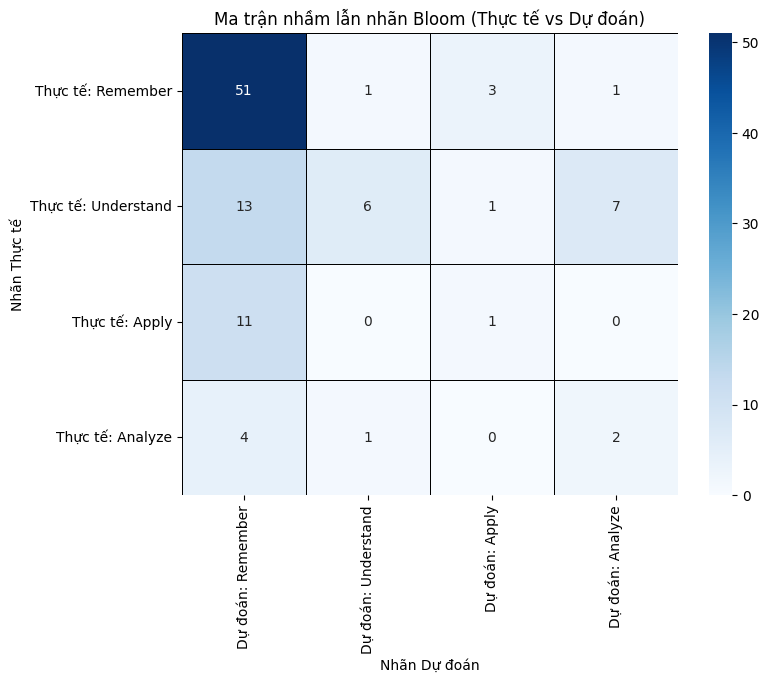

2025-07-01 16:32:09,975 - INFO - 
ƒê·ªô ch√≠nh x√°c (nh√£n Bloom) tr√™n 110 m·ª•c chung: 61.82%
2025-07-01 16:32:09,977 - INFO - Cohen's Kappa (nh√£n Bloom) gi·ªØa Ng∆∞·ªùi v√† M√°y: 0.3642
2025-07-01 16:32:09,978 - INFO - 
--- B√°o c√°o ph√¢n lo·∫°i (Precision, Recall, F1-score theo t·ª´ng nh√£n) ---
2025-07-01 16:32:09,989 - INFO - 
F1-score t·ªïng th·ªÉ (weighted avg) cho Nh√£n Bloom: 0.5356


              precision    recall  f1-score   support

    Remember       0.65      0.91      0.76        56
  Understand       0.75      0.22      0.34        27
       Apply       0.20      0.08      0.12        12
     Analyze       0.20      0.29      0.24         7

   micro avg       0.59      0.59      0.59       102
   macro avg       0.45      0.38      0.36       102
weighted avg       0.59      0.59      0.54       102


K·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom (LLM Few-Shot):
  ƒê·ªô ch√≠nh x√°c (Nh√£n Bloom): 61.82%
  Cohen's Kappa (Nh√£n Bloom): 0.3642
  F1-score t·ªïng th·ªÉ (Nh√£n Bloom): 0.5356


In [26]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report, f1_score
import numpy as np
import seaborn as sns # Import th∆∞ vi·ªán seaborn
import matplotlib.pyplot as plt # Import th∆∞ vi·ªán matplotlib ƒë·ªÉ hi·ªÉn th·ªã bi·ªÉu ƒë·ªì

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def normalize_answer(s: str) -> str:
    """
    Chu·∫©n h√≥a c√¢u tr·∫£ l·ªùi: chuy·ªÉn v·ªÅ ch·ªØ th∆∞·ªùng, lo·∫°i b·ªè d·∫•u c√¢u, lo·∫°i b·ªè kho·∫£ng tr·∫Øng th·ª´a.
    V√≠ d·ª•: "Xin ch√†o, th·∫ø gi·ªõi!" -> "xin chao the gioi"
    """
    def remove_punc(text):
        # Gi·ªØ l·∫°i c√°c k√Ω t·ª± ch·ªØ c√°i, s·ªë v√† kho·∫£ng tr·∫Øng. Lo·∫°i b·ªè t·∫•t c·∫£ c√°c k√Ω t·ª± kh√°c.
        return re.sub(r'[^\w\s]', '', text)

    def lower_and_strip(text):
        return text.lower().strip()

    s = lower_and_strip(s)
    s = remove_punc(s)
    # Thay th·∫ø nhi·ªÅu kho·∫£ng tr·∫Øng th√†nh m·ªôt kho·∫£ng tr·∫Øng duy nh·∫•t
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """
    T√≠nh F1 score d·ª±a tr√™n s·ª± tr√πng l·∫∑p token gi·ªØa c√¢u tr·∫£ l·ªùi d·ª± ƒëo√°n v√† c√¢u tr·∫£ l·ªùi th·∫≠t.
    ƒê√¢y l√† c√°ch t√≠nh F1 score th∆∞·ªùng d√πng trong c√°c b√†i to√°n Question Answering (v√≠ d·ª• SQuAD).
    """
    # Chu·∫©n h√≥a v√† t√°ch token
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát: c·∫£ hai chu·ªói ƒë·ªÅu r·ªóng
    if not prediction_tokens and not ground_truth_tokens:
        return 1.0 # Coi nh∆∞ tr√πng kh·ªõp ho√†n h·∫£o n·∫øu c·∫£ hai ƒë·ªÅu kh√¥ng c√≥ n·ªôi dung
    # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p m·ªôt trong hai chu·ªói r·ªóng
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0 # Kh√¥ng c√≥ s·ª± tr√πng kh·ªõp n·∫øu m·ªôt b√™n r·ªóng

    # ƒê·∫øm s·ªë l·∫ßn xu·∫•t hi·ªán c·ªßa m·ªói token trong c·∫£ hai chu·ªói
    # Counter gi√∫p x·ª≠ l√Ω c√°c t·ª´ l·∫∑p l·∫°i (v√≠ d·ª•: "a a b" v√† "a b b" -> common "a b")
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0.0

    # T√≠nh Precision (ƒê·ªô ch√≠nh x√°c) v√† Recall (ƒê·ªô ph·ªß)
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    
    # Tr√°nh chia cho 0 n·∫øu precision v√† recall ƒë·ªÅu b·∫±ng 0
    if precision + recall == 0:
        return 0.0
    
    # T√≠nh F1 score
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip() # X·ª≠ l√Ω tr∆∞·ªùng h·ª£p kh√¥ng ph·∫£i chu·ªói (v√≠ d·ª• NaN)

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip() # Tr·∫£ v·ªÅ nguy√™n b·∫£n n·∫øu kh√¥ng kh·ªõp (ho·∫∑c r·ªóng n·∫øu kh√¥ng c√≥ g√¨)


def evaluate_bloom_labels(human_labeled_path: str, llm_labeled_path: str,
                          id_column: str = 'question', 
                          human_bloom_label_column: str = 'bloom', # T√™n c·ªôt nh√£n Bloom cho file c·ªßa ng∆∞·ªùi
                          llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]: # T√™n c·ªôt nh√£n Bloom cho file c·ªßa m√°y
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom
    v√† in ra Confusion Matrix, Accuracy, v√† Cohen's Kappa.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c (v√≠ d·ª•: 'question').
                         C·ªôt n√†y s·∫Ω ƒë∆∞·ª£c d√πng ƒë·ªÉ kh·ªõp c√°c m·ª•c gi·ªØa hai file.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a c√°c metric v√† confusion matrix,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa ng∆∞·ªùi t·ª´: {human_labeled_path}")
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        logger.info(f"ƒê√£ t·∫£i {len(human_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa ng∆∞·ªùi.")
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa m√°y t·ª´: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        logger.info(f"ƒê√£ t·∫£i {len(llm_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa m√°y.")

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    # L·∫∑p qua c√°c m·ª•c trong d·ªØ li·ªáu c·ªßa ng∆∞·ªùi v√† t√¨m c√°c m·ª•c chung v·ªõi d·ªØ li·ªáu c·ªßa m√°y
    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                # L·∫•y nh√£n c·ªßa ng∆∞·ªùi (t·ª´ CSV, c·ªôt 'bloom')
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw) # ƒê·∫£m b·∫£o chu·∫©n h√≥a n·∫øu c·∫ßn

                # L·∫•y nh√£n c·ªßa m√°y (t·ª´ JSON, c·ªôt 'bloom_label')
                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw) # Tr√≠ch xu·∫•t ch·ªâ c·∫•p ƒë·ªô Bloom

                # B·ªè qua c√°c nh√£n r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t
                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    logger.info(f"T√¨m th·∫•y {common_items_count} m·ª•c chung ƒë·ªÉ t√≠nh ƒë·ªìng thu·∫≠n nh√£n Bloom.")

    # ƒê·ªãnh nghƒ©a c√°c nh√£n Bloom theo th·ª© t·ª± mong mu·ªën
    # ƒê·∫£m b·∫£o c√°c nh√£n n√†y kh·ªõp ch√≠nh x√°c v·ªõi c√°c nh√£n trong d·ªØ li·ªáu c·ªßa b·∫°n (v√≠ d·ª•: vi·∫øt hoa/th∆∞·ªùng)
    # N·∫øu c√≥ c√°c nh√£n kh√°c ngo√†i 4 nh√£n n√†y, ch√∫ng s·∫Ω kh√¥ng ƒë∆∞·ª£c bao g·ªìm trong ma tr·∫≠n n·∫øu b·∫°n ch·ªâ ƒë·ªãnh labels
    # N·∫øu b·∫°n mu·ªën t·ª± ƒë·ªông ph√°t hi·ªán t·∫•t c·∫£ c√°c nh√£n, h√£y d√πng:
    # all_labels = sorted(list(set(true_labels + predicted_labels)))
    # Tuy nhi√™n, vi·ªác ƒë·ªãnh nghƒ©a r√µ r√†ng gi√∫p ƒë·∫£m b·∫£o th·ª© t·ª± v√† bao g·ªìm c√°c nh√£n c√≥ th·ªÉ kh√¥ng xu·∫•t hi·ªán trong t·∫≠p con d·ªØ li·ªáu n√†y.
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze']

    # 1. T√≠nh Confusion Matrix
    # cm[i, j] l√† s·ªë l∆∞·ª£ng m·∫´u th·ª±c t·∫ø thu·ªôc l·ªõp i ƒë∆∞·ª£c d·ª± ƒëo√°n l√† l·ªõp j
    cm = confusion_matrix(true_labels, predicted_labels, labels=bloom_categories)
    cm_df = pd.DataFrame(cm, index=[f'Th·ª±c t·∫ø: {l}' for l in bloom_categories], columns=[f'D·ª± ƒëo√°n: {l}' for l in bloom_categories])
    
    logger.info("\n--- Ma tr·∫≠n nh·∫ßm l·∫´n cho Nh√£n Bloom ---")
    # Thay v√¨ print(cm_df), ch√∫ng ta s·∫Ω v·∫Ω heatmap
    plt.figure(figsize=(8, 6)) # K√≠ch th∆∞·ªõc bi·ªÉu ƒë·ªì
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, linecolor='black')
    plt.title('Ma tr·∫≠n nh·∫ßm l·∫´n nh√£n Bloom (Th·ª±c t·∫ø vs D·ª± ƒëo√°n)')
    plt.xlabel('Nh√£n D·ª± ƒëo√°n')
    plt.ylabel('Nh√£n Th·ª±c t·∫ø')
    plt.show() # Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì

    # 2. T√≠nh Accuracy
    acc = accuracy_score(true_labels, predicted_labels) * 100
    logger.info(f"\nƒê·ªô ch√≠nh x√°c (nh√£n Bloom) tr√™n {common_items_count} m·ª•c chung: {acc:.2f}%")

    # 3. T√≠nh Cohen's Kappa (th√≠ch h·ª£p cho 2 ng∆∞·ªùi ƒë√°nh gi√°)
    kappa = cohen_kappa_score(true_labels, predicted_labels)
    logger.info(f"Cohen's Kappa (nh√£n Bloom) gi·ªØa Ng∆∞·ªùi v√† M√°y: {kappa:.4f}")

    # 4. In b√°o c√°o ph√¢n lo·∫°i chi ti·∫øt h∆°n (Precision, Recall, F1-score cho t·ª´ng l·ªõp)
    logger.info("\n--- B√°o c√°o ph√¢n lo·∫°i (Precision, Recall, F1-score theo t·ª´ng nh√£n) ---")
    # zero_division=0 ƒë·ªÉ tr√°nh c·∫£nh b√°o/l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o
    report_dict = classification_report(true_labels, predicted_labels, labels=bloom_categories, output_dict=True, zero_division=0)
    print(classification_report(true_labels, predicted_labels, labels=bloom_categories, zero_division=0)) # In b√°o c√°o d·∫°ng b·∫£ng

    # L·∫•y F1-score t·ªïng th·ªÉ (weighted average)
    overall_f1_bloom = report_dict['weighted avg']['f1-score']
    logger.info(f"\nF1-score t·ªïng th·ªÉ (weighted avg) cho Nh√£n Bloom: {overall_f1_bloom:.4f}")

    return {
        'confusion_matrix': cm_df,
        'accuracy_bloom': acc,
        'cohen_kappa': kappa,
        'f1_score_bloom': overall_f1_bloom # Th√™m F1-score t·ªïng th·ªÉ v√†o k·∫øt qu·∫£ tr·∫£ v·ªÅ
    }

# --- Ch·∫°y ch∆∞∆°ng tr√¨nh ---
if __name__ == "__main__":
    # --- ƒê√°nh gi√° nh√£n Bloom v√† Confusion Matrix cho LLM Few-Shot ---
    # ƒê∆∞·ªùng d·∫´n ƒë·∫øn file nh√£n Bloom c·ªßa ng∆∞·ªùi (ground truth)
    human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
    # ƒê∆∞·ªùng d·∫´n ƒë·∫øn file nh√£n Bloom c·ªßa LLM Few-Shot
    few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

    # ƒê·∫£m b·∫£o c√°c t√™n c·ªôt n√†y kh·ªõp v·ªõi t√™n c·ªôt trong file c·ªßa b·∫°n
    ITEM_ID_COLUMN = 'question' # C·ªôt ID ƒë·ªÉ kh·ªõp c√°c m·ª•c
    HUMAN_BLOOM_LABEL_COLUMN = 'bloom' # T√™n c·ªôt nh√£n Bloom trong file CSV c·ªßa ng∆∞·ªùi
    LLM_BLOOM_LABEL_COLUMN = 'bloom_label' # T√™n c·ªôt nh√£n Bloom trong file JSON c·ªßa m√°y (c·∫£ few-shot v√† zero-shot)

    logger.info("\n========== ƒê√°nh gi√° ƒê·ªìng thu·∫≠n Nh√£n Bloom v√† Ma tr·∫≠n nh·∫ßm l·∫´n cho LLM Few-Shot ==========")
    bloom_results_few_shot = evaluate_bloom_labels(
        human_labeled_path=human_bloom_path,
        llm_labeled_path=few_shot_llm_bloom_path,
        id_column=ITEM_ID_COLUMN,
        human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
        llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
    )

    if bloom_results_few_shot:
        print(f"\nK·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom (LLM Few-Shot):")
        print(f"  ƒê·ªô ch√≠nh x√°c (Nh√£n Bloom): {bloom_results_few_shot['accuracy_bloom']:.2f}%")
        print(f"  Cohen's Kappa (Nh√£n Bloom): {bloom_results_few_shot['cohen_kappa']:.4f}")
        print(f"  F1-score t·ªïng th·ªÉ (Nh√£n Bloom): {bloom_results_few_shot['f1_score_bloom']:.4f}")
        # Ma tr·∫≠n nh·∫ßm l·∫´n v√† b√°o c√°o ph√¢n lo·∫°i ƒë√£ ƒë∆∞·ª£c in tr·ª±c ti·∫øp trong h√†m


In [36]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

# C·∫•u h√¨nh logger (ƒë·∫£m b·∫£o kh√¥ng b·ªã tr√πng l·∫∑p c·∫•u h√¨nh n·∫øu ƒë√£ c√≥ ·ªü c√°c √¥ kh√°c)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh T-test ---
# (C√°c h√†m n√†y ƒë∆∞·ª£c sao ch√©p t·ª´ code tr∆∞·ªõc ƒë√≥ ƒë·ªÉ ƒë·∫£m b·∫£o √¥ code n√†y ƒë·ªôc l·∫≠p)

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho T-test,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    # logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa ng∆∞·ªùi t·ª´: {human_labeled_path}") # B·ªè log chi ti·∫øt ƒë·ªÉ tr√°nh l√†m ƒë·∫ßy output
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        # logger.info(f"ƒê√£ t·∫£i {len(human_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa ng∆∞·ªùi.")
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    # logger.info(f"ƒêang t·∫£i d·ªØ li·ªáu g·∫Øn nh√£n c·ªßa m√°y t·ª´: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        # logger.info(f"ƒê√£ t·∫£i {len(llm_df_indexed)} m·ª•c t·ª´ d·ªØ li·ªáu c·ªßa m√°y.")

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    # logger.info(f"T√¨m th·∫•y {common_items_count} m·ª•c chung ƒë·ªÉ t√≠nh ƒë·ªìng thu·∫≠n nh√£n Bloom.") # B·ªè log chi ti·∫øt

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_per_item_accuracy(true_labels: List[str], predicted_labels: List[str]) -> List[float]:
    """
    T√≠nh to√°n ƒë·ªô ch√≠nh x√°c tr√™n t·ª´ng m·ª•c (1.0 n·∫øu ƒë√∫ng, 0.0 n·∫øu sai).
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    per_item_acc = [1.0 if t == p else 0.0 for t, p in zip(true_labels, predicted_labels)]
    return per_item_acc

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a cho hai m·∫´u ƒë·ªôc l·∫≠p.

    Args:
        scores1 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© nh·∫•t (v√≠ d·ª•: few-shot).
        scores2 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© hai (v√≠ d·ª•: no-shot).
        alpha (float): M·ª©c √Ω nghƒ©a (significance level).
        hypothesis (str): "greater" n·∫øu scores1 > scores2, "less" n·∫øu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary ch·ª©a th·ªëng k√™ t, gi√° tr·ªã p, v√† k·∫øt lu·∫≠n.
    """
    if not scores1 or not scores2:
        logger.warning("Kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß d·ªØ li·ªáu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("C·∫ßn √≠t nh·∫•t 2 m·∫´u trong m·ªói nh√≥m ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß m·∫´u ƒë·ªÉ th·ª±c hi·ªán T-test."}

    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Lu√¥n t√≠nh p-value m·ªôt ph√≠a

    print(f"\nKi·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: Few-shot t·ªët h∆°n No-shot):")
    print(f"  Gi√° tr·ªã trung b√¨nh nh√≥m Few-shot: {mean1:.4f}")
    print(f"  Gi√° tr·ªã trung b√¨nh nh√≥m No-shot: {mean2:.4f}")
    print(f"  Th·ªëng k√™ T: {t_statistic:.4f}")
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {p_value_one_tailed:.4f}")
    print(f"  M·ª©c √Ω nghƒ©a alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"B√°c b·ªè H0. Few-shot t·ªët h∆°n no-shot m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.4f})."
        else:
            conclusion = f"Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng Few-shot t·ªët h∆°n no-shot m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.4f})."
    else: # Tr∆∞·ªùng h·ª£p kh√°c (v√≠ d·ª• "less" ho·∫∑c hai ph√≠a)
        conclusion = "Ki·ªÉm ƒë·ªãnh kh√¥ng ph√π h·ª£p v·ªõi gi·∫£ thuy·∫øt 'greater'."


    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- L·∫•y nh√£n t·ª´ c√°c file few-shot v√† no-shot ---
logger.info("\n========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test ==========")

# L·∫•y nh√£n cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# L·∫•y nh√£n cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Th·ª±c hi·ªán T-test so s√°nh Few-Shot v√† No-Shot ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh Few-Shot v√† No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    per_item_accuracy_no_shot = get_per_item_accuracy(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels']
    )
    per_item_accuracy_few_shot = get_per_item_accuracy(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels']
    )

    # ƒê·∫£m b·∫£o r·∫±ng s·ªë l∆∞·ª£ng m·∫´u l√† nh∆∞ nhau (v√¨ ch√∫ng ta so s√°nh tr√™n c√πng m·ªôt t·∫≠p c√¢u h·ªèi)
    if len(per_item_accuracy_no_shot) != len(per_item_accuracy_few_shot):
        logger.error("S·ªë l∆∞·ª£ng m·ª•c chung gi·ªØa Ground Truth v√† LLM No-Shot/Few-Shot kh√¥ng kh·ªõp. Kh√¥ng th·ªÉ th·ª±c hi·ªán T-test.")
    else:
        # Th·ª±c hi·ªán T-test m·ªôt ph√≠a (H1: few-shot t·ªët h∆°n no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=per_item_accuracy_few_shot, # Nh√≥m 1: Few-shot
            scores2=per_item_accuracy_no_shot,  # Nh√≥m 2: No-shot
            hypothesis="greater" # Gi·∫£ thuy·∫øt: Few-shot t·ªët h∆°n No-shot
        )
        print(f"\nK·∫øt qu·∫£ T-test:")
        print(f"  Th·ªëng k√™ T: {t_test_results['t_statistic']:.4f}")
        print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  K·∫øt lu·∫≠n: {t_test_results['conclusion']}")
else:
    logger.error("Kh√¥ng ƒë·ªß k·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom t·ª´ c·∫£ hai m√¥ h√¨nh ƒë·ªÉ th·ª±c hi·ªán T-test.")


2025-07-01 17:24:59,260 - INFO - 
========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test ==========
2025-07-01 17:24:59,401 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh Few-Shot v√† No-Shot ==========



Ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: Few-shot t·ªët h∆°n No-shot):
  Gi√° tr·ªã trung b√¨nh nh√≥m Few-shot: 0.6182
  Gi√° tr·ªã trung b√¨nh nh√≥m No-shot: 0.5818
  Th·ªëng k√™ T: 0.5484
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.2920
  M·ª©c √Ω nghƒ©a alpha: 0.05

K·∫øt qu·∫£ T-test:
  Th·ªëng k√™ T: 0.5484
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.2920
  K·∫øt lu·∫≠n: Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng Few-shot t·ªët h∆°n no-shot m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p=0.2920).


2025-07-01 16:46:25,047 - INFO - 
========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test (F1-score) ==========
2025-07-01 16:46:25,087 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-score c·ªßa Few-Shot v√† No-Shot ==========



Ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: Few-shot t·ªët h∆°n No-shot):
  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m Few-shot: 0.5355
  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m No-shot: 0.5041
  Th·ªëng k√™ T: 12.5228
  Gi√° tr·ªã P (hai ph√≠a): 0.000000000
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.000000000
  M·ª©c √Ω nghƒ©a alpha: 0.05


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_19672\2584228763.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})


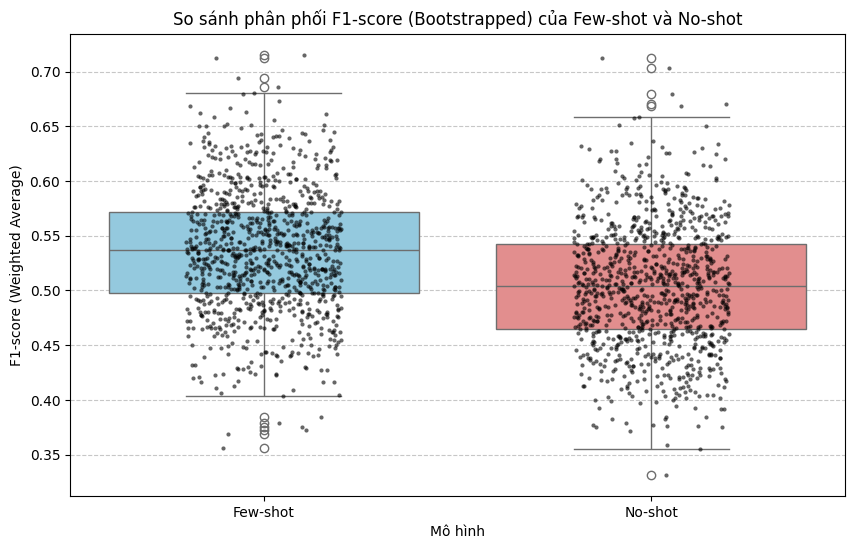

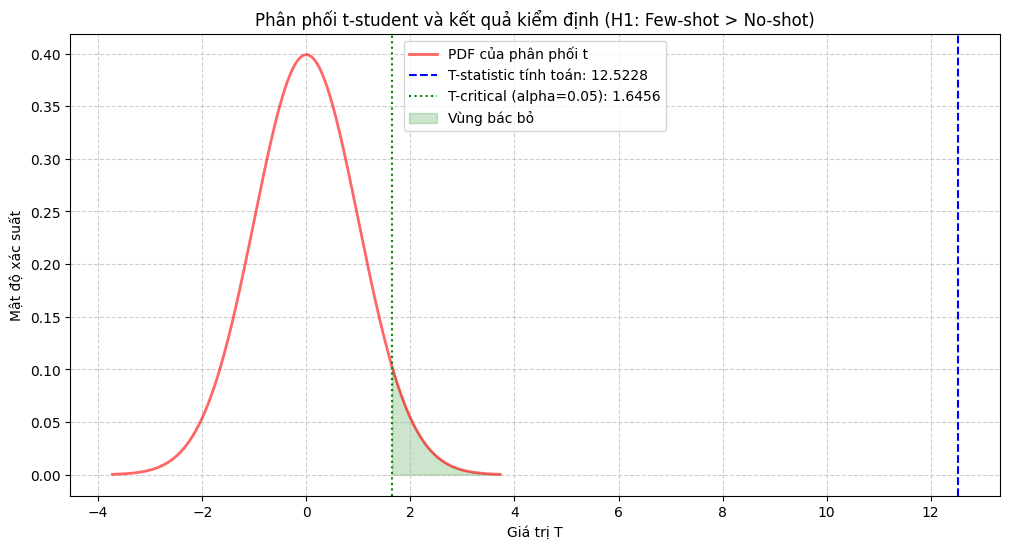

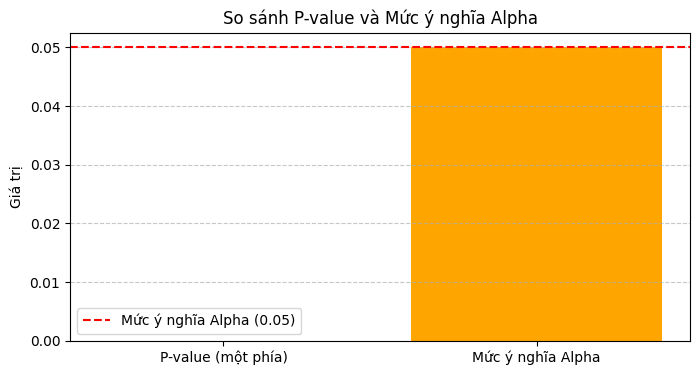


K·∫øt qu·∫£ T-test:
  Th·ªëng k√™ T: 12.5228
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.0000
  K·∫øt lu·∫≠n: B√°c b·ªè H0. Few-shot t·ªët h∆°n No-shot m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p=0.000000000).


In [30]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from scipy import stats
import seaborn as sns # Import th∆∞ vi·ªán seaborn
import matplotlib.pyplot as plt # Import th∆∞ vi·ªán matplotlib ƒë·ªÉ hi·ªÉn th·ªã bi·ªÉu ƒë·ªì

# C·∫•u h√¨nh logger (ƒë·∫£m b·∫£o kh√¥ng b·ªã tr√πng l·∫∑p c·∫•u h√¨nh n·∫øu ƒë√£ c√≥ ·ªü c√°c √¥ kh√°c)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh T-test ---
# (C√°c h√†m n√†y ƒë∆∞·ª£c sao ch√©p t·ª´ code tr∆∞·ªõc ƒë√≥ ƒë·ªÉ ƒë·∫£m b·∫£o √¥ code n√†y ƒë·ªôc l·∫≠p)

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho T-test,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 1000) -> List[float]:
    """
    T·∫°o ra ph√¢n ph·ªëi F1-score b·∫±ng ph∆∞∆°ng ph√°p bootstrapping.

    Args:
        true_labels (List[str]): Danh s√°ch nh√£n th·ª±c t·∫ø.
        predicted_labels (List[str]): Danh s√°ch nh√£n d·ª± ƒëo√°n.
        n_bootstraps (int): S·ªë l·∫ßn l·∫•y m·∫´u l·∫°i.

    Returns:
        List[float]: Danh s√°ch c√°c F1-score t·ªïng th·ªÉ (weighted avg) t·ª´ c√°c m·∫´u l·∫°i.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] # ƒê·∫£m b·∫£o c√°c nh√£n kh·ªõp

    for _ in range(n_bootstraps):
        # L·∫•y m·∫´u l·∫°i c√°c ch·ªâ s·ªë v·ªõi thay th·∫ø
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # T·∫°o c√°c m·∫´u l·∫°i c·ªßa nh√£n
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # T√≠nh F1-score cho m·∫´u l·∫°i
        # S·ª≠ d·ª•ng zero_division=0 ƒë·ªÉ tr√°nh l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong m·∫´u l·∫°i
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # L·∫•y F1-score t·ªïng th·ªÉ (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a cho hai m·∫´u ƒë·ªôc l·∫≠p v√† v·∫Ω bi·ªÉu ƒë·ªì so s√°nh.

    Args:
        scores1 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© nh·∫•t (v√≠ d·ª•: few-shot).
        scores2 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© hai (v√≠ d·ª•: no-shot).
        scores1_name (str): T√™n c·ªßa nh√≥m th·ª© nh·∫•t (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        scores2_name (str): T√™n c·ªßa nh√≥m th·ª© hai (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        alpha (float): M·ª©c √Ω nghƒ©a (significance level).
        hypothesis (str): "greater" n·∫øu scores1 > scores2, "less" n·∫øu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary ch·ª©a th·ªëng k√™ t, gi√° tr·ªã p, v√† k·∫øt lu·∫≠n.
    """
    if not scores1 or not scores2:
        logger.warning("Kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß d·ªØ li·ªáu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("C·∫ßn √≠t nh·∫•t 2 m·∫´u trong m·ªói nh√≥m ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß m·∫´u ƒë·ªÉ th·ª±c hi·ªán T-test."}

    # Th·ª±c hi·ªán T-test ƒë·ªôc l·∫≠p (Welch's t-test, kh√¥ng gi·∫£ ƒë·ªãnh ph∆∞∆°ng sai b·∫±ng nhau)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Lu√¥n t√≠nh p-value m·ªôt ph√≠a

    print(f"\nKi·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: {scores1_name} t·ªët h∆°n {scores2_name}):")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m {scores1_name}: {mean1:.4f}")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m {scores2_name}: {mean2:.4f}")
    print(f"  Th·ªëng k√™ T: {t_statistic:.4f}")
    print(f"  Gi√° tr·ªã P (hai ph√≠a): {p_value_two_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {p_value_one_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  M·ª©c √Ω nghƒ©a alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"B√°c b·ªè H0. {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Ki·ªÉm ƒë·ªãnh kh√¥ng ph√π h·ª£p v·ªõi gi·∫£ thuy·∫øt 'greater'."

    # --- V·∫Ω bi·ªÉu ƒë·ªì h·ªôp so s√°nh ph√¢n ph·ªëi F1-score ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'M√¥ h√¨nh': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-score': scores1 + scores2
    })
    sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Th√™m c√°c ƒëi·ªÉm d·ªØ li·ªáu
    plt.title(f'So s√°nh ph√¢n ph·ªëi F1-score (Bootstrapped) c·ªßa {scores1_name} v√† {scores2_name}')
    plt.ylabel('F1-score (Weighted Average)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ---
    plt.figure(figsize=(12, 6))

    # ∆Ø·ªõc l∆∞·ª£ng b·∫≠c t·ª± do cho t-distribution (cho m·ª•c ƒë√≠ch tr·ª±c quan h√≥a)
    # V·ªõi bootstrapping 1000 m·∫´u, df s·∫Ω r·∫•t l·ªõn, g·∫ßn nh∆∞ ph√¢n ph·ªëi chu·∫©n.
    df_approx = len(scores1) + len(scores2) - 2 
    if df_approx < 1:
        df_approx = 1 # ƒê·∫£m b·∫£o df t·ªëi thi·ªÉu l√† 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label='PDF c·ªßa ph√¢n ph·ªëi t')

    # ƒê√°nh d·∫•u t-statistic ƒë∆∞·ª£c t√≠nh to√°n
    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic t√≠nh to√°n: {t_statistic:.4f}')

    # ƒê√°nh d·∫•u gi√° tr·ªã t-critical cho ki·ªÉm ƒë·ªãnh m·ªôt ph√≠a
    critical_value = stats.t.ppf(1 - alpha, df_approx) # Cho H1: scores1 > scores2
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    # T√¥ m√†u v√πng b√°c b·ªè
    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='V√πng b√°c b·ªè')

    plt.title(f'Ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Gi√° tr·ªã T')
    plt.ylabel('M·∫≠t ƒë·ªô x√°c su·∫•t')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì so s√°nh P-value v√† Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (m·ªôt ph√≠a)', 'M·ª©c √Ω nghƒ©a Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'M·ª©c √Ω nghƒ©a Alpha ({alpha})')
    plt.title('So s√°nh P-value v√† M·ª©c √Ω nghƒ©a Alpha')
    plt.ylabel('Gi√° tr·ªã')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- L·∫•y nh√£n t·ª´ c√°c file few-shot v√† no-shot ---
logger.info("\n========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test (F1-score) ==========")

# L·∫•y nh√£n cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# L·∫•y nh√£n cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Th·ª±c hi·ªán T-test so s√°nh Few-Shot v√† No-Shot ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-score c·ªßa Few-Shot v√† No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    # T·∫°o ph√¢n ph·ªëi F1-score b·∫±ng bootstrapping
    f1_scores_distribution_no_shot = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels']
    )
    f1_scores_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels']
    )

    # ƒê·∫£m b·∫£o c√≥ ƒë·ªß d·ªØ li·ªáu t·ª´ bootstrapping
    if not f1_scores_distribution_no_shot or not f1_scores_distribution_few_shot:
        logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu F1-score t·ª´ bootstrapping ƒë·ªÉ th·ª±c hi·ªán T-test.")
    else:
        # Th·ª±c hi·ªán T-test m·ªôt ph√≠a (H1: few-shot t·ªët h∆°n no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=f1_scores_distribution_few_shot, # Nh√≥m 1: Few-shot
            scores2=f1_scores_distribution_no_shot,  # Nh√≥m 2: No-shot
            scores1_name="Few-shot", # T√™n cho bi·ªÉu ƒë·ªì
            scores2_name="No-shot",  # T√™n cho bi·ªÉu ƒë·ªì
            hypothesis="greater" # Gi·∫£ thuy·∫øt: Few-shot t·ªët h∆°n No-shot
        )
        print(f"\nK·∫øt qu·∫£ T-test:")
        print(f"  Th·ªëng k√™ T: {t_test_results['t_statistic']:.4f}")
        print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  K·∫øt lu·∫≠n: {t_test_results['conclusion']}")
else:
    logger.error("Kh√¥ng ƒë·ªß k·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom t·ª´ c·∫£ hai m√¥ h√¨nh ƒë·ªÉ th·ª±c hi·ªán T-test.")


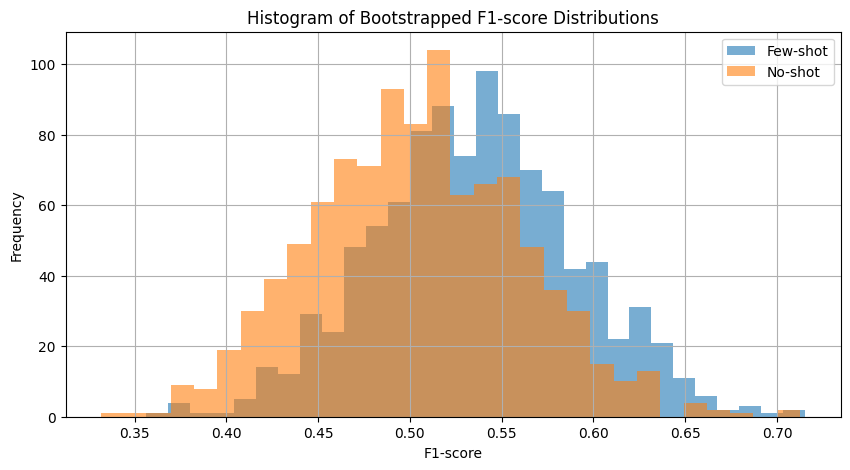

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(f1_scores_distribution_few_shot, bins=30, alpha=0.6, label='Few-shot')
plt.hist(f1_scores_distribution_no_shot, bins=30, alpha=0.6, label='No-shot')
plt.title('Histogram of Bootstrapped F1-score Distributions')
plt.xlabel('F1-score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
print("üìä Few-shot F1 samples (10):", f1_scores_distribution_few_shot[:10])
print("üìä No-shot  F1 samples (10):", f1_scores_distribution_no_shot[:10])


üìä Few-shot F1 samples (10): [0.5493369215818196, 0.5250385579332948, 0.5400552875800401, 0.4679736002448223, 0.5660061919504643, 0.5874009178139341, 0.5140540533695666, 0.5046722856668973, 0.5818748003832641, 0.35605987678090106]
üìä No-shot  F1 samples (10): [0.5677838102624811, 0.5092403335125388, 0.5294375591405295, 0.41103146853146855, 0.5203883495145631, 0.5882785839149725, 0.5169533310400184, 0.510522032321823, 0.5753676470588236, 0.5815710209781185]


In [33]:
print(f"üî¢ S·ªë m·∫´u bootstrapped: Few-shot = {len(f1_scores_distribution_few_shot)}, No-shot = {len(f1_scores_distribution_no_shot)}")
print(f"üìà Few-shot: Min = {min(f1_scores_distribution_few_shot):.4f}, Max = {max(f1_scores_distribution_few_shot):.4f}")
print(f"üìâ No-shot : Min = {min(f1_scores_distribution_no_shot):.4f}, Max = {max(f1_scores_distribution_no_shot):.4f}")


üî¢ S·ªë m·∫´u bootstrapped: Few-shot = 1000, No-shot = 1000
üìà Few-shot: Min = 0.3561, Max = 0.7154
üìâ No-shot : Min = 0.3316, Max = 0.7125


In [35]:
import numpy as np

def compute_cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt((std1 ** 2 + std2 ** 2) / 2)
    d = (mean1 - mean2) / pooled_std
    return d

cohen_d = compute_cohens_d(f1_scores_distribution_few_shot, f1_scores_distribution_no_shot)
print(f"Cohen's d: {cohen_d:.4f}")


Cohen's d: 0.5600


Trung b√¨nh ƒë·ªô ch√≠nh x√°c Softmax: 0.6598
Trung b√¨nh ƒë·ªô ch√≠nh x√°c Random Forest: 0.6644
T-statistic = -0.1939
P-value = 0.8506
‚ö†Ô∏è K·∫øt lu·∫≠n: KH√îNG c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa Softmax v√† Random Forest.


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3504810395.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])


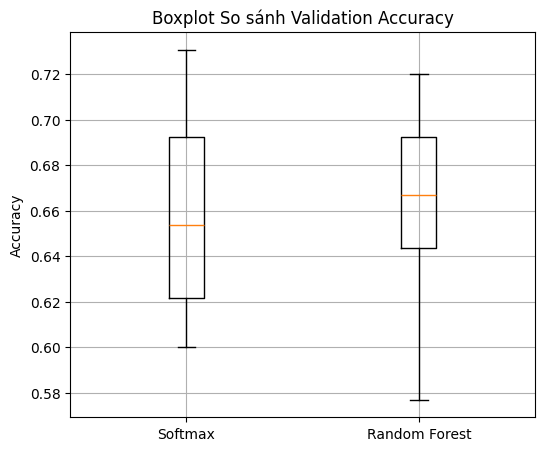

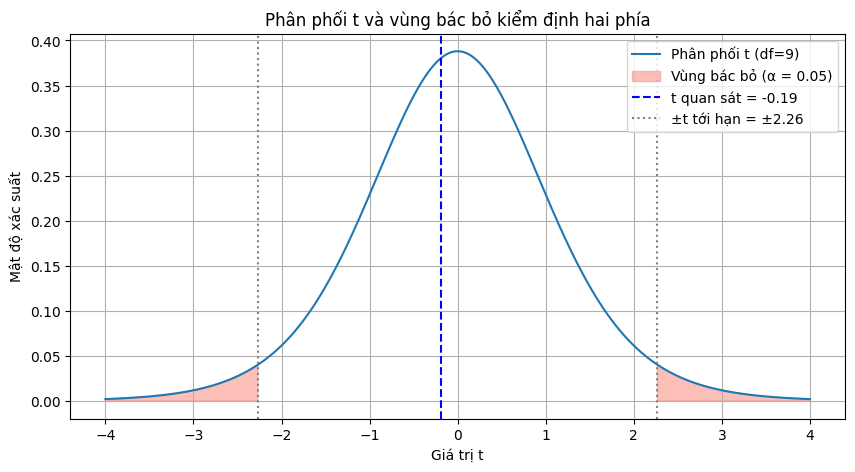

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t

# ======= D·ªØ li·ªáu =======
softmax_val_acc = [0.6923, 0.6154, 0.7308, 0.6538, 0.6538,
                   0.6923, 0.6000, 0.7200, 0.6400, 0.6000]
rf_val_acc = [0.6923, 0.6538, 0.6154, 0.5769, 0.6538,
              0.6923, 0.7200, 0.6800, 0.6400, 0.7200]

# ======= T√≠nh trung b√¨nh & ki·ªÉm ƒë·ªãnh T-test =======
mean_softmax = np.mean(softmax_val_acc)
mean_rf = np.mean(rf_val_acc)
t_stat, p_value = ttest_rel(softmax_val_acc, rf_val_acc)

# ======= In k·∫øt qu·∫£ v√† K·∫æT LU·∫¨N =======
print(f"Trung b√¨nh ƒë·ªô ch√≠nh x√°c Softmax: {mean_softmax:.4f}")
print(f"Trung b√¨nh ƒë·ªô ch√≠nh x√°c Random Forest: {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}")
print(f"P-value = {p_value:.4f}")

# ======= K·∫æT LU·∫¨N =======
alpha = 0.05
if p_value < alpha:
    if mean_rf > mean_softmax:
        print("‚úÖ K·∫øt lu·∫≠n: Random Forest c√≥ ƒë·ªô ch√≠nh x√°c cao h∆°n v√† s·ª± kh√°c bi·ªát n√†y C√ì √Ω nghƒ©a th·ªëng k√™.")
    else:
        print("‚úÖ K·∫øt lu·∫≠n: Softmax c√≥ ƒë·ªô ch√≠nh x√°c cao h∆°n v√† s·ª± kh√°c bi·ªát n√†y C√ì √Ω nghƒ©a th·ªëng k√™.")
else:
    print("‚ö†Ô∏è K·∫øt lu·∫≠n: KH√îNG c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa Softmax v√† Random Forest.")

# ======= Boxplot =======
plt.figure(figsize=(6, 5))
plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])
plt.title("Boxplot So s√°nh Validation Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ======= V·∫Ω ph√¢n ph·ªëi t v·ªõi v√πng b√°c b·ªè =======
df = len(softmax_val_acc) - 1
t_crit = t.ppf(1 - alpha/2, df)
x = np.linspace(-4, 4, 500)
y = t.pdf(x, df)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Ph√¢n ph·ªëi t (df={df})")
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="V√πng b√°c b·ªè (Œ± = 0.05)")
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan s√°t = {t_stat:.2f}")
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"¬±t t·ªõi h·∫°n = ¬±{t_crit:.2f}")
plt.axvline(t_crit, color='gray', linestyle=':')
plt.title("Ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè ki·ªÉm ƒë·ªãnh hai ph√≠a")
plt.xlabel("Gi√° tr·ªã t")
plt.ylabel("M·∫≠t ƒë·ªô x√°c su·∫•t")
plt.legend()
plt.grid(True)
plt.show()



===> T-TEST SOFTMAX vs RANDOM FOREST:
Trung b√¨nh Softmax: 0.6598
Trung b√¨nh Random Forest: 0.6644
T-statistic = -0.1939, P-value = 0.8506
‚ö†Ô∏è K·∫øt lu·∫≠n: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa hai m√¥ h√¨nh.

===> ANOVA ki·ªÉm ƒë·ªãnh s·ª± kh√°c bi·ªát gi·ªØa c√°c nh√≥m fold:
F-statistic = 0.0488, P-value = 0.8277
‚ö†Ô∏è K·∫øt lu·∫≠n ANOVA: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát ƒë√°ng k·ªÉ gi·ªØa c√°c fold.


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\89696658.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])


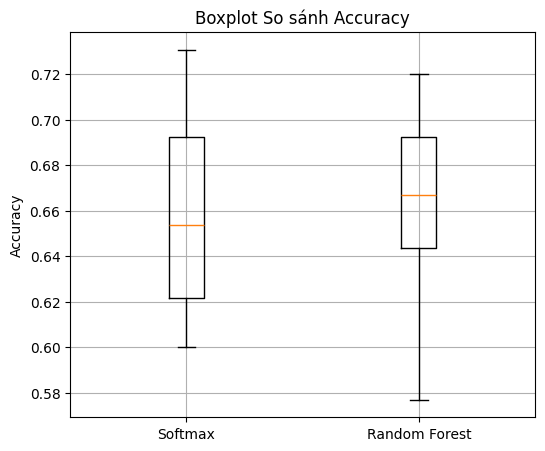

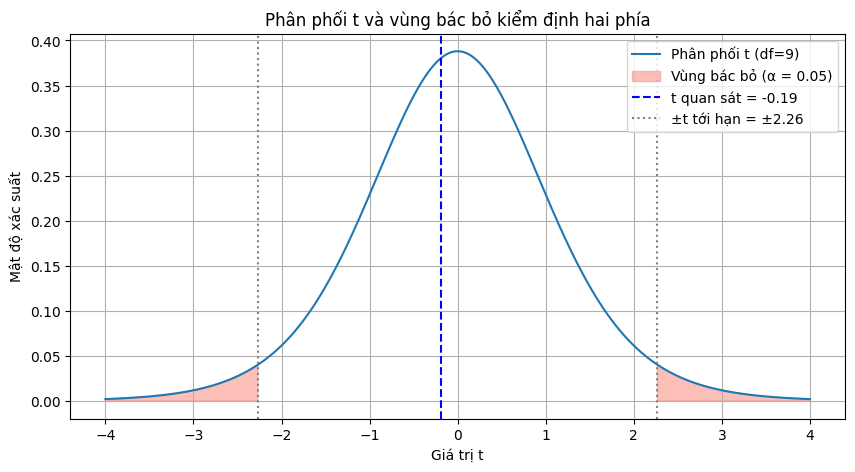

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t, f_oneway

# ======= D·ªØ li·ªáu =======
softmax_val_acc = [0.6923, 0.6154, 0.7308, 0.6538, 0.6538,
                   0.6923, 0.6000, 0.7200, 0.6400, 0.6000]
rf_val_acc = [0.6923, 0.6538, 0.6154, 0.5769, 0.6538,
              0.6923, 0.7200, 0.6800, 0.6400, 0.7200]

# ======= Trung b√¨nh v√† T-test =======
mean_softmax = np.mean(softmax_val_acc)
mean_rf = np.mean(rf_val_acc)
t_stat, p_value = ttest_rel(softmax_val_acc, rf_val_acc)

print(f"\n===> T-TEST SOFTMAX vs RANDOM FOREST:")
print(f"Trung b√¨nh Softmax: {mean_softmax:.4f}")
print(f"Trung b√¨nh Random Forest: {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_value:.4f}")

# ======= K·∫øt lu·∫≠n T-test =======
alpha = 0.05
if p_value < alpha:
    better_model = "Random Forest" if mean_rf > mean_softmax else "Softmax"
    print(f"‚úÖ K·∫øt lu·∫≠n: {better_model} t·ªët h∆°n v√† s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™.")
else:
    print("‚ö†Ô∏è K·∫øt lu·∫≠n: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa hai m√¥ h√¨nh.")

# ======= ANOVA ƒë·ªÉ so s√°nh c√°c fold =======
anova_stat, anova_p = f_oneway(softmax_val_acc, rf_val_acc)

print(f"\n===> ANOVA ki·ªÉm ƒë·ªãnh s·ª± kh√°c bi·ªát gi·ªØa c√°c nh√≥m fold:")
print(f"F-statistic = {anova_stat:.4f}, P-value = {anova_p:.4f}")

if anova_p < alpha:
    print("‚úÖ K·∫øt lu·∫≠n ANOVA: C√≥ √≠t nh·∫•t m·ªôt nh√≥m (fold) c√≥ k·∫øt qu·∫£ kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™.")
else:
    print("‚ö†Ô∏è K·∫øt lu·∫≠n ANOVA: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát ƒë√°ng k·ªÉ gi·ªØa c√°c fold.")

# ======= Boxplot so s√°nh hai m√¥ h√¨nh =======
plt.figure(figsize=(6, 5))
plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])
plt.title("Boxplot So s√°nh Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ======= Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè =======
df = len(softmax_val_acc) - 1
t_crit = t.ppf(1 - alpha/2, df)
x = np.linspace(-4, 4, 500)
y = t.pdf(x, df)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Ph√¢n ph·ªëi t (df={df})")
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="V√πng b√°c b·ªè (Œ± = 0.05)")
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan s√°t = {t_stat:.2f}")
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"¬±t t·ªõi h·∫°n = ¬±{t_crit:.2f}")
plt.axvline(t_crit, color='gray', linestyle=':')
plt.title("Ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè ki·ªÉm ƒë·ªãnh hai ph√≠a")
plt.xlabel("Gi√° tr·ªã t")
plt.ylabel("M·∫≠t ƒë·ªô x√°c su·∫•t")
plt.legend()
plt.grid(True)
plt.show()


2025-07-01 23:35:20,714 - INFO - 
========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot ==========
2025-07-01 23:35:20,810 - INFO - ƒê√£ t·∫°o 10 m·∫´u F1-score cho LLM Few-shot b·∫±ng bootstrapping.
2025-07-01 23:35:20,811 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh ANOVA so s√°nh F1-score c·ªßa LLM Few-Shot, Softmax v√† Random Forest ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\4159445413.py:245: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_for_boxplot,



===> K·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ANOVA gi·ªØa LLM Few-Shot, Softmax v√† Random Forest:
F-statistic: 30.0563
P-value: 0.000000136
‚úÖ K·∫øt lu·∫≠n: C√≥ √≠t nh·∫•t m·ªôt nh√≥m c√≥ k·∫øt qu·∫£ F1-score kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ (p < 0.05).
   (D·ª±a tr√™n gi√° tr·ªã trung b√¨nh, LLM Few-shot (0.5385) c√≥ v·∫ª v∆∞·ª£t tr·ªôi h∆°n Softmax (0.3662) v√† Random Forest (0.2732).)
   ƒê·ªÉ x√°c nh·∫≠n LLM Few-shot v∆∞·ª£t tr·ªôi h∆°n C·ª§ TH·ªÇ t·ª´ng m√¥ h√¨nh, c·∫ßn th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh Post-hoc.


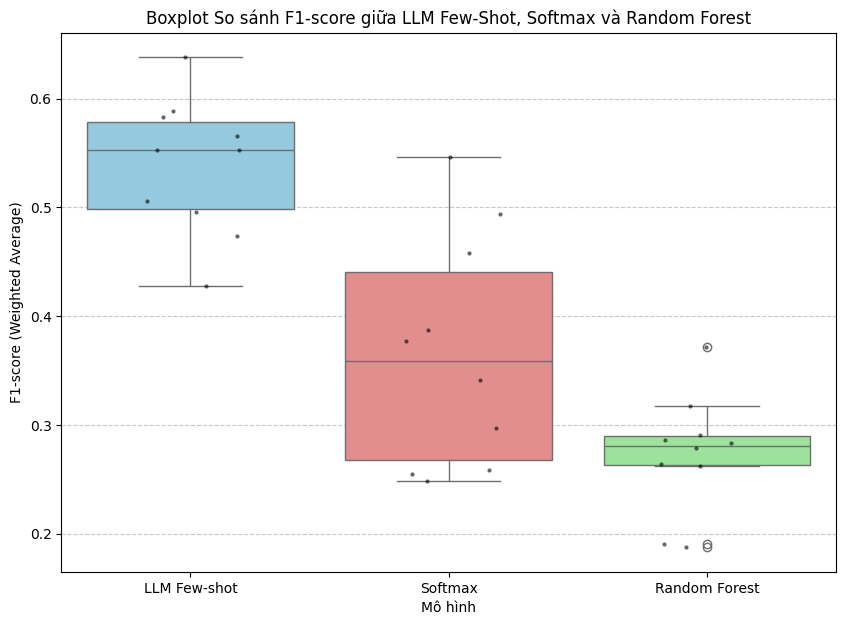

In [21]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import numpy as np
from scipy import stats
from scipy.stats import f_oneway # Import f_oneway for ANOVA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# C·∫•u h√¨nh logger (ƒë·∫£m b·∫£o kh√¥ng b·ªã tr√πng l·∫∑p c·∫•u h√¨nh n·∫øu ƒë√£ c√≥ ·ªü c√°c √¥ kh√°c)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh to√°n ---

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho c√°c ki·ªÉm ƒë·ªãnh th·ªëng k√™,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    T·∫°o ra ph√¢n ph·ªëi F1-score b·∫±ng ph∆∞∆°ng ph√°p bootstrapping.

    Args:
        true_labels (List[str]): Danh s√°ch nh√£n th·ª±c t·∫ø.
        predicted_labels (List[str]): Danh s√°ch nh√£n d·ª± ƒëo√°n.
        n_bootstraps (int): S·ªë l·∫ßn l·∫•y m·∫´u l·∫°i.

    Returns:
        List[float]: Danh s√°ch c√°c F1-score t·ªïng th·ªÉ (weighted avg) t·ª´ c√°c m·∫´u l·∫°i.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # ƒê·∫£m b·∫£o c√°c nh√£n kh·ªõp v·ªõi c√°c nh√£n c√≥ th·ªÉ c√≥ trong d·ªØ li·ªáu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # L·∫•y m·∫´u l·∫°i c√°c ch·ªâ s·ªë v·ªõi thay th·∫ø
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # T·∫°o c√°c m·∫´u l·∫°i c·ªßa nh√£n
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # T√≠nh F1-score cho m·∫´u l·∫°i
        # S·ª≠ d·ª•ng zero_division=0 ƒë·ªÉ tr√°nh l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong m·∫´u l·∫°i
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # L·∫•y F1-score t·ªïng th·ªÉ (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- D·ªØ li·ªáu F1-score c·ªßa c√°c m√¥ h√¨nh ML (ƒë∆∞·ª£c c·∫≠p nh·∫≠t t·ª´ d·ªØ li·ªáu b·∫°n cung c·∫•p) ---
# ƒê√¢y l√† F1-macro scores t·ª´ 10 folds c·ªßa b·∫°n
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 
rf_val_f1 = [0.3718, 0.2625, 0.1905, 0.3173, 0.2857,
             0.2787, 0.2907, 0.2833, 0.1875, 0.2637] 

# --- L·∫•y nh√£n t·ª´ file LLM Few-Shot v√† t·∫°o ph√¢n ph·ªëi F1-score ---
logger.info("\n========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # ƒê·∫∑t s·ªë l·∫ßn bootstrap l√† 10
    )
    logger.info(f"ƒê√£ t·∫°o {len(f1_distribution_few_shot)} m·∫´u F1-score cho LLM Few-shot b·∫±ng bootstrapping.")
else:
    logger.error("Kh√¥ng th·ªÉ t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot. Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh.")
    f1_distribution_few_shot = [] # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói

# --- Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh ANOVA ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh ANOVA so s√°nh F1-score c·ªßa LLM Few-Shot, Softmax v√† Random Forest ==========")

# ƒê·∫£m b·∫£o c√≥ ƒë·ªß d·ªØ li·ªáu t·ª´ t·∫•t c·∫£ c√°c nh√≥m
if f1_distribution_few_shot and softmax_val_f1 and rf_val_f1:
    # Th·ª±c hi·ªán ANOVA
    anova_f_statistic, anova_p_value = f_oneway(f1_distribution_few_shot, softmax_val_f1, rf_val_f1)

    print(f"\n===> K·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ANOVA gi·ªØa LLM Few-Shot, Softmax v√† Random Forest:")
    print(f"F-statistic: {anova_f_statistic:.4f}")
    print(f"P-value: {anova_p_value:.9f}") # In p-value v·ªõi ƒë·ªô ch√≠nh x√°c cao h∆°n

    # K·∫øt lu·∫≠n cho ANOVA (ki·ªÉm ƒë·ªãnh hai ph√≠a)
    if anova_p_value < 0.05:
        print("‚úÖ K·∫øt lu·∫≠n: C√≥ √≠t nh·∫•t m·ªôt nh√≥m c√≥ k·∫øt qu·∫£ F1-score kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ (p < 0.05).")
        
        mean_llm_few_shot = np.mean(f1_distribution_few_shot)
        mean_softmax = np.mean(softmax_val_f1)
        mean_rf = np.mean(rf_val_f1)

        # Ki·ªÉm tra xem LLM Few-shot c√≥ gi√° tr·ªã trung b√¨nh cao nh·∫•t kh√¥ng
        if mean_llm_few_shot > mean_softmax and mean_llm_few_shot > mean_rf:
            print(f"   (D·ª±a tr√™n gi√° tr·ªã trung b√¨nh, LLM Few-shot ({mean_llm_few_shot:.4f}) c√≥ v·∫ª v∆∞·ª£t tr·ªôi h∆°n Softmax ({mean_softmax:.4f}) v√† Random Forest ({mean_rf:.4f}).)")
            print("   ƒê·ªÉ x√°c nh·∫≠n LLM Few-shot v∆∞·ª£t tr·ªôi h∆°n C·ª§ TH·ªÇ t·ª´ng m√¥ h√¨nh, c·∫ßn th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh Post-hoc.")
        else:
            print("   (C·∫ßn th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh Post-hoc ƒë·ªÉ x√°c ƒë·ªãnh nh√≥m n√†o kh√°c bi·ªát v√† theo h∆∞·ªõng n√†o.)")
    else:
        print("‚ö†Ô∏è K·∫øt lu·∫≠n: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát ƒë√°ng k·ªÉ v·ªÅ F1-score gi·ªØa c√°c nh√≥m (p >= 0.05).")

    # ======= V·∫Ω boxplot so s√°nh F1-score =======
    plt.figure(figsize=(10, 7))
    
    # Chu·∫©n b·ªã d·ªØ li·ªáu cho boxplot
    data_for_boxplot = pd.DataFrame({
        'M√¥ h√¨nh': ['LLM Few-shot'] * len(f1_distribution_few_shot) +
                   ['Softmax'] * len(softmax_val_f1) +
                   ['Random Forest'] * len(rf_val_f1),
        'F1-score': f1_distribution_few_shot + softmax_val_f1 + rf_val_f1
    })

    sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-score', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So s√°nh F1-score gi·ªØa LLM Few-Shot, Softmax v√† Random Forest")
    plt.ylabel("F1-score (Weighted Average)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu t·ª´ m·ªôt ho·∫∑c nhi·ªÅu nh√≥m ƒë·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh ANOVA.")



===> T-TEST SOFTMAX vs RANDOM FOREST (F1-score):
Trung b√¨nh Softmax (F1-macro): 0.3662
Trung b√¨nh Random Forest (F1-macro): 0.2732
T-statistic = 2.9941, P-value = 0.015100688
‚úÖ K·∫øt lu·∫≠n: Softmax t·ªët h∆°n v√† s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ v·ªÅ F1-score (p=0.015100688).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\123739120.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})


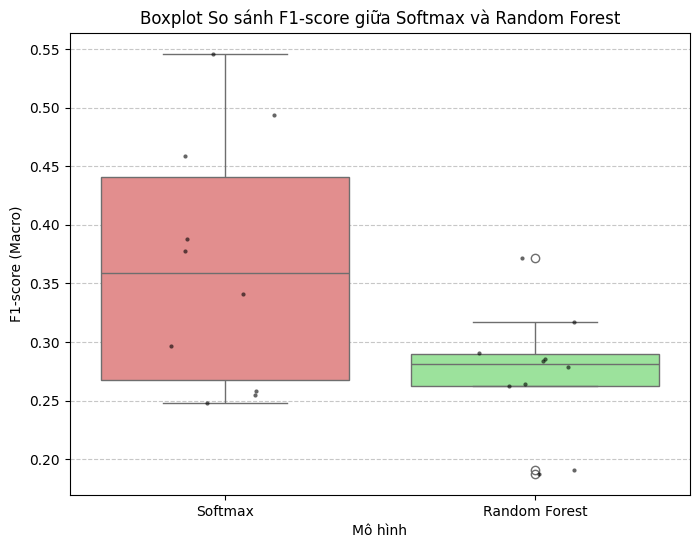

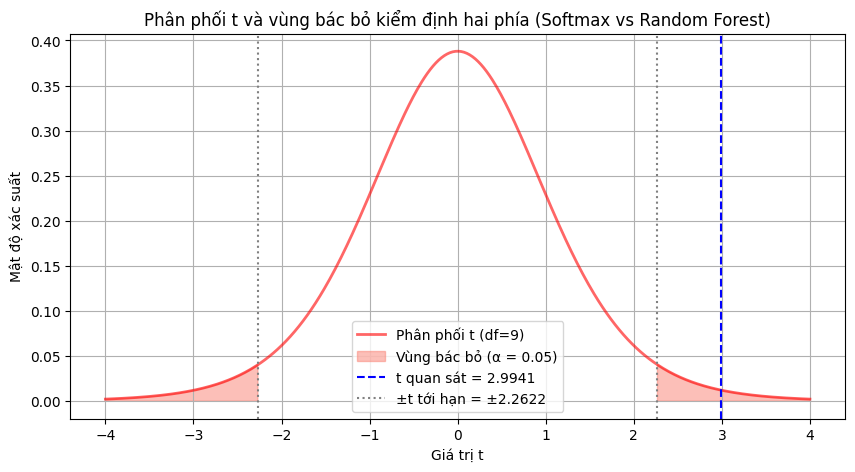

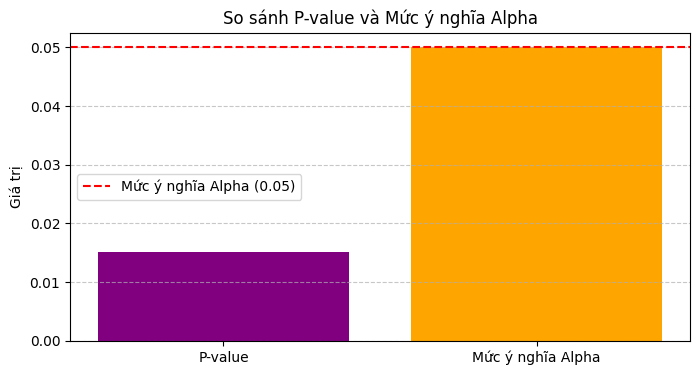

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t, f_oneway # f_oneway is imported but not used for this specific request
import pandas as pd # Imported for general utility, not strictly needed for this specific code block
import logging
import seaborn as sns

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- D·ªØ li·ªáu F1-score c·ªßa c√°c m√¥ h√¨nh ML (F1-macro scores t·ª´ 10 folds) ---
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 
rf_val_f1 = [0.3718, 0.2625, 0.1905, 0.3173, 0.2857,
             0.2787, 0.2907, 0.2833, 0.1875, 0.2637] 

# --- Ki·ªÉm ƒë·ªãnh T-test gi·ªØa Softmax v√† Random Forest ---
# S·ª≠ d·ª•ng ttest_rel v√¨ ƒë√¢y l√† d·ªØ li·ªáu t·ª´ c√°c fold (c√≥ th·ªÉ coi l√† c·∫∑p)
mean_softmax = np.mean(softmax_val_f1)
mean_rf = np.mean(rf_val_f1)
t_stat, p_value = ttest_rel(softmax_val_f1, rf_val_f1)

print(f"\n===> T-TEST SOFTMAX vs RANDOM FOREST (F1-score):")
print(f"Trung b√¨nh Softmax (F1-macro): {mean_softmax:.4f}")
print(f"Trung b√¨nh Random Forest (F1-macro): {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_value:.9f}") # In p-value v·ªõi ƒë·ªô ch√≠nh x√°c cao h∆°n

# ======= K·∫øt lu·∫≠n T-test =======
alpha = 0.05
if p_value < alpha:
    # X√°c ƒë·ªãnh m√¥ h√¨nh n√†o t·ªët h∆°n d·ª±a tr√™n gi√° tr·ªã trung b√¨nh
    better_model = "Random Forest" if mean_rf > mean_softmax else "Softmax"
    print(f"‚úÖ K·∫øt lu·∫≠n: {better_model} t·ªët h∆°n v√† s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ v·ªÅ F1-score (p={p_value:.9f}).")
else:
    print(f"‚ö†Ô∏è K·∫øt lu·∫≠n: Kh√¥ng c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ v·ªÅ F1-score gi·ªØa hai m√¥ h√¨nh Softmax v√† Random Forest (p={p_value:.9f}).")

# ======= Boxplot so s√°nh hai m√¥ h√¨nh =======
plt.figure(figsize=(8, 6))
data_to_plot = pd.DataFrame({
    'M√¥ h√¨nh': ['Softmax'] * len(softmax_val_f1) + ['Random Forest'] * len(rf_val_f1),
    'F1-score': softmax_val_f1 + rf_val_f1
})
sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})
sns.stripplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6)
plt.title("Boxplot So s√°nh F1-score gi·ªØa Softmax v√† Random Forest")
plt.ylabel("F1-score (Macro)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ======= Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè =======
# B·∫≠c t·ª± do cho paired t-test l√† n - 1, v·ªõi n l√† s·ªë c·∫∑p (s·ªë folds)
df = len(softmax_val_f1) - 1 
t_crit = stats.t.ppf(1 - alpha/2, df) # t-critical cho ki·ªÉm ƒë·ªãnh hai ph√≠a
x = np.linspace(-4, 4, 500) # Ph·∫°m vi gi√° tr·ªã t ƒë·ªÉ v·∫Ω
y = stats.t.pdf(x, df) # M·∫≠t ƒë·ªô x√°c su·∫•t c·ªßa ph√¢n ph·ªëi t

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Ph√¢n ph·ªëi t (df={df})", color='red', lw=2, alpha=0.6)
# T√¥ m√†u v√πng b√°c b·ªè (hai ph√≠a)
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="V√πng b√°c b·ªè (Œ± = 0.05)")
# V·∫Ω ƒë∆∞·ªùng t-statistic quan s√°t
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan s√°t = {t_stat:.4f}")
# V·∫Ω ƒë∆∞·ªùng t-critical
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"¬±t t·ªõi h·∫°n = ¬±{t_crit:.4f}")
plt.axvline(t_crit, color='gray', linestyle=':')

plt.title("Ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè ki·ªÉm ƒë·ªãnh hai ph√≠a (Softmax vs Random Forest)")
plt.xlabel("Gi√° tr·ªã t")
plt.ylabel("M·∫≠t ƒë·ªô x√°c su·∫•t")
plt.legend()
plt.grid(True)
plt.show()

# ======= Bi·ªÉu ƒë·ªì so s√°nh P-value v√† Alpha =======
plt.figure(figsize=(8, 4))
bar_labels = ['P-value', 'M·ª©c √Ω nghƒ©a Alpha']
bar_values = [p_value, alpha]
colors = ['purple' if p_value < alpha else 'orange', 'orange']

plt.bar(bar_labels, bar_values, color=colors)
plt.axhline(alpha, color='red', linestyle='--', label=f'M·ª©c √Ω nghƒ©a Alpha ({alpha})')
plt.title('So s√°nh P-value v√† M·ª©c √Ω nghƒ©a Alpha')
plt.ylabel('Gi√° tr·ªã')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


2025-07-01 23:53:47,860 - INFO - 
========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot ==========
2025-07-01 23:53:47,944 - INFO - ƒê√£ t·∫°o 10 m·∫´u F1-score cho LLM Few-shot b·∫±ng bootstrapping.
2025-07-01 23:53:47,945 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-score c·ªßa LLM Few-Shot v√† Softmax ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\179666543.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})



Ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: LLM Few-shot t·ªët h∆°n Softmax):
  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m LLM Few-shot: 0.5366
  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m Softmax: 0.3662
  Th·ªëng k√™ T: 4.8550
  Gi√° tr·ªã P (hai ph√≠a): 0.000548858
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.000274429
  M·ª©c √Ω nghƒ©a alpha: 0.05


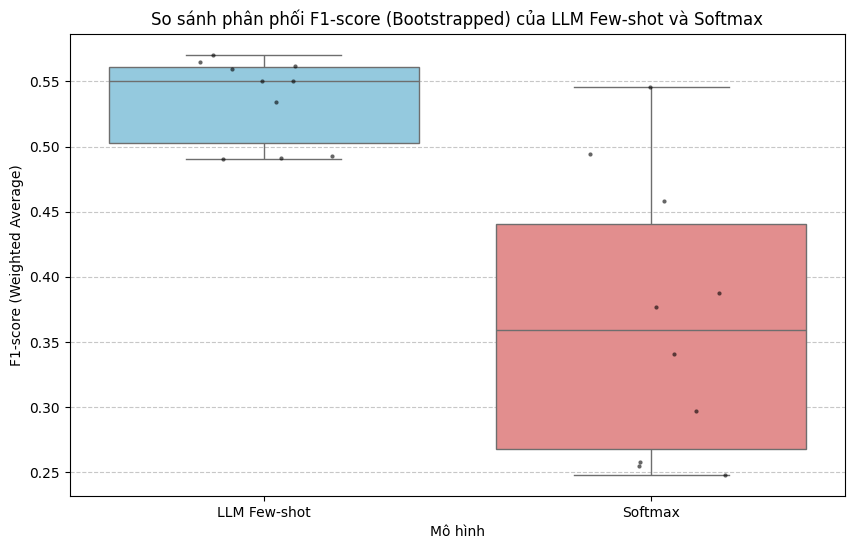

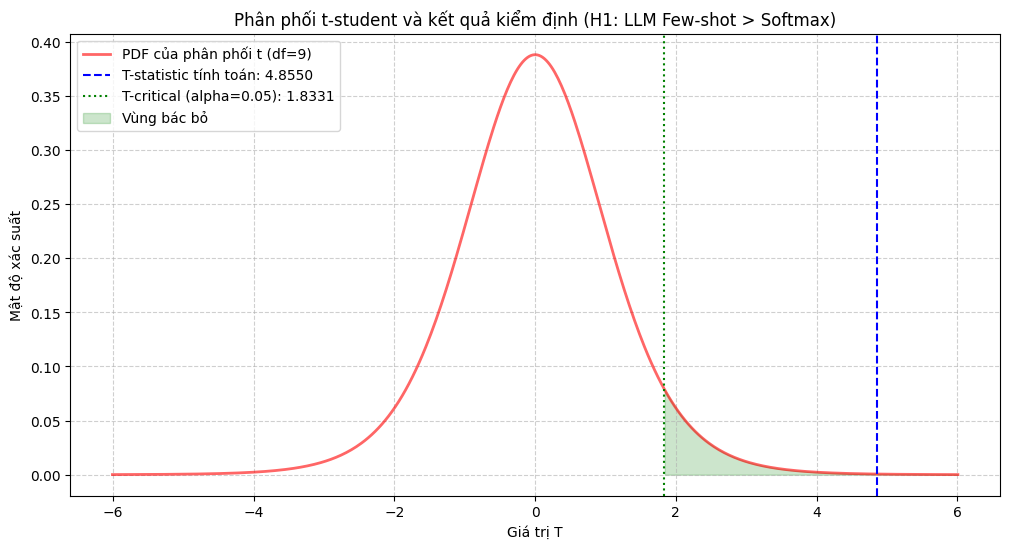

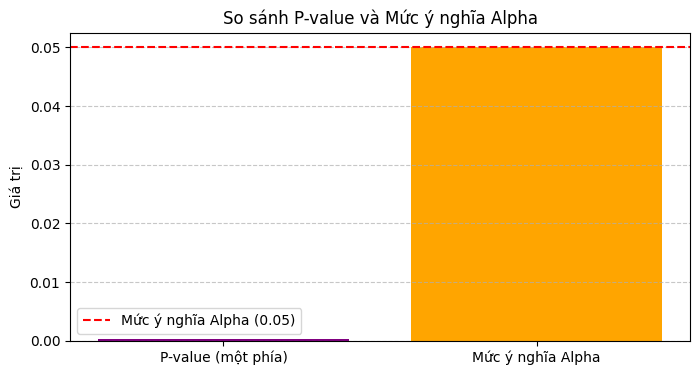


K·∫øt qu·∫£ T-test (LLM Few-shot vs Softmax):
  Th·ªëng k√™ T: 4.8550
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.0003
  K·∫øt lu·∫≠n: B√°c b·ªè H0. LLM Few-shot t·ªët h∆°n Softmax m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p=0.000274429).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\179666543.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_for_boxplot,


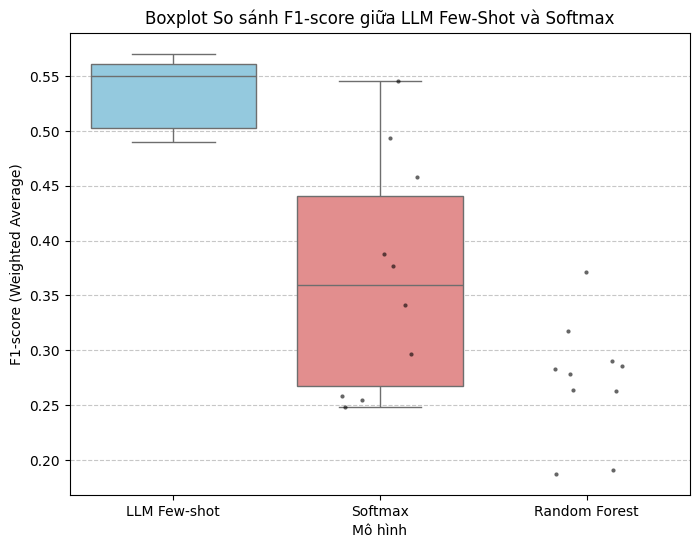

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # Changed to ttest_ind for independent samples if needed, but will use ttest_rel if data is paired
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh to√°n ---

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho c√°c ki·ªÉm ƒë·ªãnh th·ªëng k√™,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    T·∫°o ra ph√¢n ph·ªëi F1-score b·∫±ng ph∆∞∆°ng ph√°p bootstrapping.

    Args:
        true_labels (List[str]): Danh s√°ch nh√£n th·ª±c t·∫ø.
        predicted_labels (List[str]): Danh s√°ch nh√£n d·ª± ƒëo√°n.
        n_bootstraps (int): S·ªë l·∫ßn l·∫•y m·∫´u l·∫°i.

    Returns:
        List[float]: Danh s√°ch c√°c F1-score t·ªïng th·ªÉ (weighted avg) t·ª´ c√°c m·∫´u l·∫°i.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # ƒê·∫£m b·∫£o c√°c nh√£n kh·ªõp v·ªõi c√°c nh√£n c√≥ th·ªÉ c√≥ trong d·ªØ li·ªáu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # L·∫•y m·∫´u l·∫°i c√°c ch·ªâ s·ªë v·ªõi thay th·∫ø
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # T·∫°o c√°c m·∫´u l·∫°i c·ªßa nh√£n
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # T√≠nh F1-score cho m·∫´u l·∫°i
        # S·ª≠ d·ª•ng zero_division=0 ƒë·ªÉ tr√°nh l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong m·∫´u l·∫°i
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # L·∫•y F1-score t·ªïng th·ªÉ (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a cho hai m·∫´u ƒë·ªôc l·∫≠p v√† v·∫Ω bi·ªÉu ƒë·ªì so s√°nh.

    Args:
        scores1 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© nh·∫•t.
        scores2 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© hai.
        scores1_name (str): T√™n c·ªßa nh√≥m th·ª© nh·∫•t (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        scores2_name (str): T√™n c·ªßa nh√≥m th·ª© hai (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        alpha (float): M·ª©c √Ω nghƒ©a (significance level).
        hypothesis (str): "greater" n·∫øu scores1 > scores2, "less" n·∫øu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary ch·ª©a th·ªëng k√™ t, gi√° tr·ªã p, v√† k·∫øt lu·∫≠n.
    """
    if not scores1 or not scores2:
        logger.warning("Kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß d·ªØ li·ªáu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("C·∫ßn √≠t nh·∫•t 2 m·∫´u trong m·ªói nh√≥m ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß m·∫´u ƒë·ªÉ th·ª±c hi·ªán T-test."}

    # S·ª≠ d·ª•ng ttest_ind v√¨ ƒë√¢y l√† c√°c m·∫´u ƒë·ªôc l·∫≠p (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Lu√¥n t√≠nh p-value m·ªôt ph√≠a

    print(f"\nKi·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: {scores1_name} t·ªët h∆°n {scores2_name}):")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m {scores1_name}: {mean1:.4f}")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-score nh√≥m {scores2_name}: {mean2:.4f}")
    print(f"  Th·ªëng k√™ T: {t_statistic:.4f}")
    print(f"  Gi√° tr·ªã P (hai ph√≠a): {p_value_two_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {p_value_one_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  M·ª©c √Ω nghƒ©a alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"B√°c b·ªè H0. {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Ki·ªÉm ƒë·ªãnh kh√¥ng ph√π h·ª£p v·ªõi gi·∫£ thuy·∫øt 'greater'."

    # --- V·∫Ω bi·ªÉu ƒë·ªì h·ªôp so s√°nh ph√¢n ph·ªëi ƒëi·ªÉm s·ªë ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'M√¥ h√¨nh': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-score': scores1 + scores2
    })
    sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Th√™m c√°c ƒëi·ªÉm d·ªØ li·ªáu
    plt.title(f'So s√°nh ph√¢n ph·ªëi F1-score (Bootstrapped) c·ªßa {scores1_name} v√† {scores2_name}')
    plt.ylabel('F1-score (Weighted Average)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t v√† v√πng b√°c b·ªè ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF c·ªßa ph√¢n ph·ªëi t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic t√≠nh to√°n: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='V√πng b√°c b·ªè')

    plt.title(f'Ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Gi√° tr·ªã T')
    plt.ylabel('M·∫≠t ƒë·ªô x√°c su·∫•t')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì so s√°nh P-value v√† Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (m·ªôt ph√≠a)', 'M·ª©c √Ω nghƒ©a Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'M·ª©c √Ω nghƒ©a Alpha ({alpha})')
    plt.title('So s√°nh P-value v√† M·ª©c √Ω nghƒ©a Alpha')
    plt.ylabel('Gi√° tr·ªã')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- D·ªØ li·ªáu F1-score c·ªßa m√¥ h√¨nh Softmax (F1-macro scores t·ª´ 10 folds) ---
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 

# --- L·∫•y nh√£n t·ª´ file LLM Few-Shot v√† t·∫°o ph√¢n ph·ªëi F1-score ---
logger.info("\n========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # ƒê·∫∑t s·ªë l·∫ßn bootstrap l√† 10
    )
    logger.info(f"ƒê√£ t·∫°o {len(f1_distribution_few_shot)} m·∫´u F1-score cho LLM Few-shot b·∫±ng bootstrapping.")
else:
    logger.error("Kh√¥ng th·ªÉ t·∫°o ph√¢n ph·ªëi F1-score cho LLM Few-Shot. Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh.")
    f1_distribution_few_shot = [] # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói

# --- Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh LLM Few-Shot v·ªõi Softmax ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-score c·ªßa LLM Few-Shot v√† Softmax ==========")

if f1_distribution_few_shot and softmax_val_f1:
    t_test_results_softmax = perform_one_tailed_t_test(
        scores1=f1_distribution_few_shot, # Nh√≥m 1: LLM Few-shot
        scores2=softmax_val_f1,           # Nh√≥m 2: Softmax
        scores1_name="LLM Few-shot", 
        scores2_name="Softmax",  
        hypothesis="greater" # Gi·∫£ thuy·∫øt: LLM Few-shot t·ªët h∆°n Softmax
    )
    print(f"\nK·∫øt qu·∫£ T-test (LLM Few-shot vs Softmax):")
    print(f"  Th·ªëng k√™ T: {t_test_results_softmax['t_statistic']:.4f}")
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {t_test_results_softmax['p_value_one_tailed']:.4f}")
    print(f"  K·∫øt lu·∫≠n: {t_test_results_softmax['conclusion']}")
else:
    logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu t·ª´ LLM Few-Shot ho·∫∑c Softmax ƒë·ªÉ th·ª±c hi·ªán T-test.")

# --- Bi·ªÉu ƒë·ªì Boxplot t·ªïng h·ª£p (ch·ªâ bao g·ªìm Few-shot v√† Softmax) ---
if f1_distribution_few_shot and softmax_val_f1:
    plt.figure(figsize=(8, 6))
    
    data_for_boxplot = pd.DataFrame({
        'M√¥ h√¨nh': ['LLM Few-shot'] * len(f1_distribution_few_shot) +
                   ['Softmax'] * len(softmax_val_f1),
        'F1-score': f1_distribution_few_shot + softmax_val_f1
    })

    sns.boxplot(x='M√¥ h√¨nh', y='F1-score', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So s√°nh F1-score gi·ªØa LLM Few-Shot v√† Softmax")
    plt.ylabel("F1-score (Weighted Average)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


2025-07-02 00:45:09,204 - INFO - 
========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-macro cho LLM Few-Shot ==========
2025-07-02 00:45:13,437 - INFO - ƒê√£ t·∫°o 1000 m·∫´u F1-macro cho LLM Few-shot b·∫±ng bootstrapping.
2025-07-02 00:45:13,438 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-macro c·ªßa LLM Few-Shot v√† Softmax ==========



Ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: LLM Few-shot t·ªët h∆°n Softmax):
  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m LLM Few-shot: 0.3565
  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m Softmax: 0.3662
  Th·ªëng k√™ T: -0.2909
  Gi√° tr·ªã P (hai ph√≠a): 0.777702428
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.388851214
  M·ª©c √Ω nghƒ©a alpha: 0.05


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\2946448995.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})


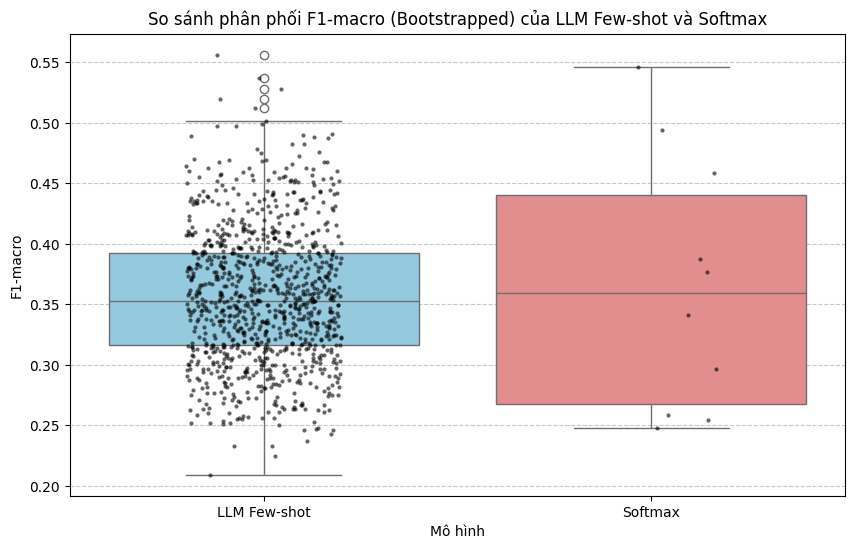

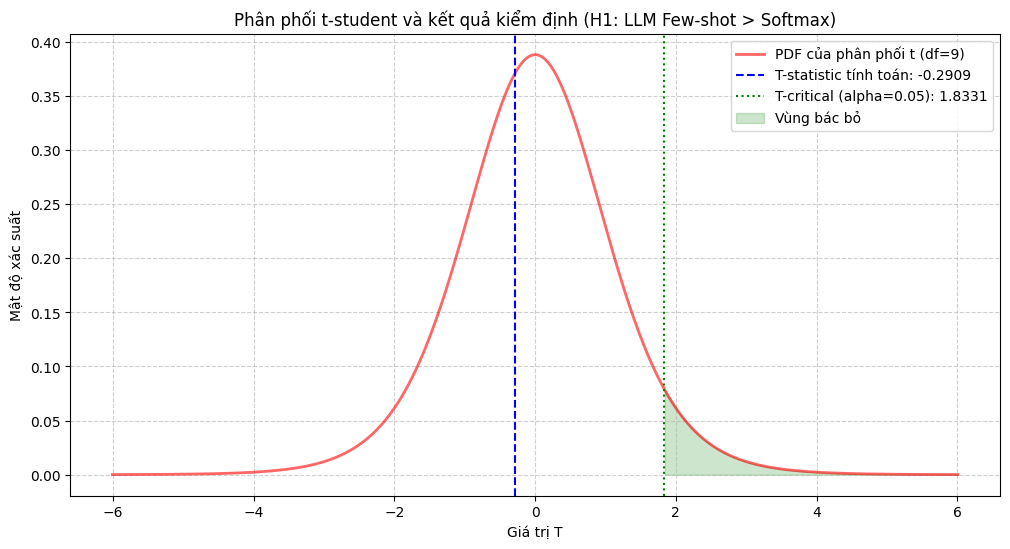

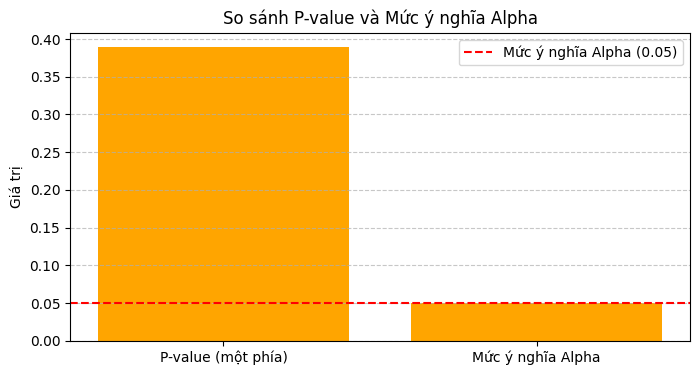


K·∫øt qu·∫£ T-test (LLM Few-shot vs Softmax):
  Th·ªëng k√™ T: -0.2909
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.3889
  K·∫øt lu·∫≠n: Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng LLM Few-shot t·ªët h∆°n Softmax m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p=0.388851214).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\2946448995.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot,


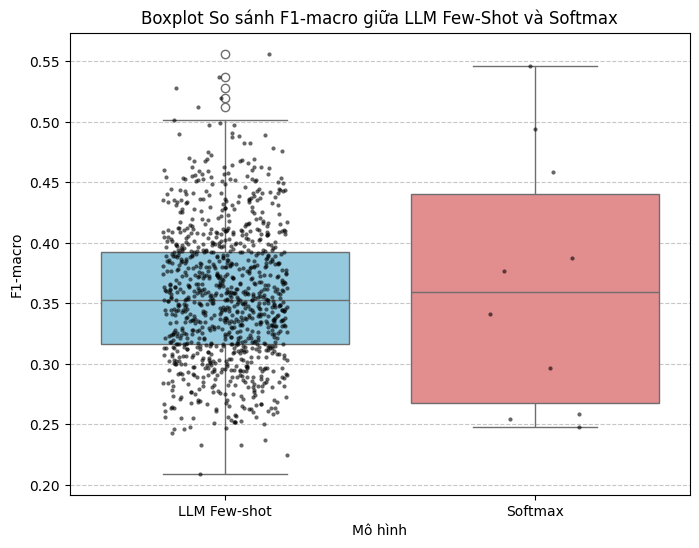

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # ttest_ind for independent samples
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh to√°n ---

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho c√°c ki·ªÉm ƒë·ªãnh th·ªëng k√™,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    T·∫°o ra ph√¢n ph·ªëi F1-score b·∫±ng ph∆∞∆°ng ph√°p bootstrapping.

    Args:
        true_labels (List[str]): Danh s√°ch nh√£n th·ª±c t·∫ø.
        predicted_labels (List[str]): Danh s√°ch nh√£n d·ª± ƒëo√°n.
        n_bootstraps (int): S·ªë l·∫ßn l·∫•y m·∫´u l·∫°i.

    Returns:
        List[float]: Danh s√°ch c√°c F1-score t·ªïng th·ªÉ (macro avg) t·ª´ c√°c m·∫´u l·∫°i.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # ƒê·∫£m b·∫£o c√°c nh√£n kh·ªõp v·ªõi c√°c nh√£n c√≥ th·ªÉ c√≥ trong d·ªØ li·ªáu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # L·∫•y m·∫´u l·∫°i c√°c ch·ªâ s·ªë v·ªõi thay th·∫ø
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # T·∫°o c√°c m·∫´u l·∫°i c·ªßa nh√£n
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # T√≠nh F1-score cho m·∫´u l·∫°i
        # S·ª≠ d·ª•ng zero_division=0 ƒë·ªÉ tr√°nh l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong m·∫´u l·∫°i
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # L·∫•y F1-score t·ªïng th·ªÉ (macro avg)
        overall_f1 = report['macro avg']['f1-score'] # L·∫•y F1-macro
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a cho hai m·∫´u ƒë·ªôc l·∫≠p v√† v·∫Ω bi·ªÉu ƒë·ªì so s√°nh.

    Args:
        scores1 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© nh·∫•t.
        scores2 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© hai.
        scores1_name (str): T√™n c·ªßa nh√≥m th·ª© nh·∫•t (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        scores2_name (str): T√™n c·ªßa nh√≥m th·ª© hai (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        alpha (float): M·ª©c √Ω nghƒ©a (significance level).
        hypothesis (str): "greater" n·∫øu scores1 > scores2, "less" n·∫øu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary ch·ª©a th·ªëng k√™ t, gi√° tr·ªã p, v√† k·∫øt lu·∫≠n.
    """
    if not scores1 or not scores2:
        logger.warning("Kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß d·ªØ li·ªáu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("C·∫ßn √≠t nh·∫•t 2 m·∫´u trong m·ªói nh√≥m ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß m·∫´u ƒë·ªÉ th·ª±c hi·ªán T-test."}

    # S·ª≠ d·ª•ng ttest_ind v√¨ ƒë√¢y l√† c√°c m·∫´u ƒë·ªôc l·∫≠p (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Lu√¥n t√≠nh p-value m·ªôt ph√≠a

    print(f"\nKi·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: {scores1_name} t·ªët h∆°n {scores2_name}):")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m {scores1_name}: {mean1:.4f}")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m {scores2_name}: {mean2:.4f}")
    print(f"  Th·ªëng k√™ T: {t_statistic:.4f}")
    print(f"  Gi√° tr·ªã P (hai ph√≠a): {p_value_two_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {p_value_one_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  M·ª©c √Ω nghƒ©a alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"B√°c b·ªè H0. {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Ki·ªÉm ƒë·ªãnh kh√¥ng ph√π h·ª£p v·ªõi gi·∫£ thuy·∫øt 'greater'."

    # --- V·∫Ω bi·ªÉu ƒë·ªì h·ªôp so s√°nh ph√¢n ph·ªëi ƒëi·ªÉm s·ªë ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'M√¥ h√¨nh': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-macro': scores1 + scores2
    })
    sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Th√™m c√°c ƒëi·ªÉm d·ªØ li·ªáu
    plt.title(f'So s√°nh ph√¢n ph·ªëi F1-macro (Bootstrapped) c·ªßa {scores1_name} v√† {scores2_name}')
    plt.ylabel('F1-macro')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF c·ªßa ph√¢n ph·ªëi t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic t√≠nh to√°n: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='V√πng b√°c b·ªè')

    plt.title(f'Ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Gi√° tr·ªã T')
    plt.ylabel('M·∫≠t ƒë·ªô x√°c su·∫•t')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì so s√°nh P-value v√† Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (m·ªôt ph√≠a)', 'M·ª©c √Ω nghƒ©a Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'M·ª©c √Ω nghƒ©a Alpha ({alpha})')
    plt.title('So s√°nh P-value v√† M·ª©c √Ω nghƒ©a Alpha')
    plt.ylabel('Gi√° tr·ªã')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- D·ªØ li·ªáu F1-macro c·ªßa m√¥ h√¨nh Softmax (t·ª´ 10 folds) ---
softmax_val_f1_macro = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                        0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 

# --- L·∫•y nh√£n t·ª´ file LLM Few-Shot v√† t·∫°o ph√¢n ph·ªëi F1-macro ---
logger.info("\n========== L·∫•y nh√£n v√† t·∫°o ph√¢n ph·ªëi F1-macro cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=1000 # ƒê·∫∑t s·ªë l·∫ßn bootstrap l√† 10
    )
    logger.info(f"ƒê√£ t·∫°o {len(f1_distribution_few_shot_macro)} m·∫´u F1-macro cho LLM Few-shot b·∫±ng bootstrapping.")
else:
    logger.error("Kh√¥ng th·ªÉ t·∫°o ph√¢n ph·ªëi F1-macro cho LLM Few-Shot. Kh√¥ng th·ªÉ th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh.")
    f1_distribution_few_shot_macro = [] # ƒê·∫∑t r·ªóng ƒë·ªÉ tr√°nh l·ªói

# --- Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh LLM Few-Shot v·ªõi Softmax ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-macro c·ªßa LLM Few-Shot v√† Softmax ==========")

if f1_distribution_few_shot_macro and softmax_val_f1_macro:
    t_test_results_softmax = perform_one_tailed_t_test(
        scores1=f1_distribution_few_shot_macro, # Nh√≥m 1: LLM Few-shot (F1-macro)
        scores2=softmax_val_f1_macro,           # Nh√≥m 2: Softmax (F1-macro)
        scores1_name="LLM Few-shot", 
        scores2_name="Softmax",  
        hypothesis="greater" # Gi·∫£ thuy·∫øt: LLM Few-shot t·ªët h∆°n Softmax
    )
    print(f"\nK·∫øt qu·∫£ T-test (LLM Few-shot vs Softmax):")
    print(f"  Th·ªëng k√™ T: {t_test_results_softmax['t_statistic']:.4f}")
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {t_test_results_softmax['p_value_one_tailed']:.4f}")
    print(f"  K·∫øt lu·∫≠n: {t_test_results_softmax['conclusion']}")
else:
    logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu t·ª´ LLM Few-Shot ho·∫∑c Softmax ƒë·ªÉ th·ª±c hi·ªán T-test.")

# --- Bi·ªÉu ƒë·ªì Boxplot t·ªïng h·ª£p (ch·ªâ bao g·ªìm Few-shot v√† Softmax) ---
if f1_distribution_few_shot_macro and softmax_val_f1_macro:
    plt.figure(figsize=(8, 6))
    
    data_for_boxplot = pd.DataFrame({
        'M√¥ h√¨nh': ['LLM Few-shot'] * len(f1_distribution_few_shot_macro) +
                   ['Softmax'] * len(softmax_val_f1_macro),
        'F1-macro': f1_distribution_few_shot_macro + softmax_val_f1_macro
    })

    sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So s√°nh F1-macro gi·ªØa LLM Few-Shot v√† Softmax")
    plt.ylabel("F1-macro")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


2025-07-02 00:43:23,438 - INFO - 
========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test (F1-macro) ==========
2025-07-02 00:43:23,478 - INFO - 
========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-macro c·ªßa Few-Shot v√† No-Shot ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3852478751.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})



Ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: Few-shot t·ªët h∆°n No-shot):
  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m Few-shot: 0.3870
  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m No-shot: 0.3101
  Th·ªëng k√™ T: 4.4225
  Gi√° tr·ªã P (hai ph√≠a): 0.000339668
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.000169834
  M·ª©c √Ω nghƒ©a alpha: 0.05


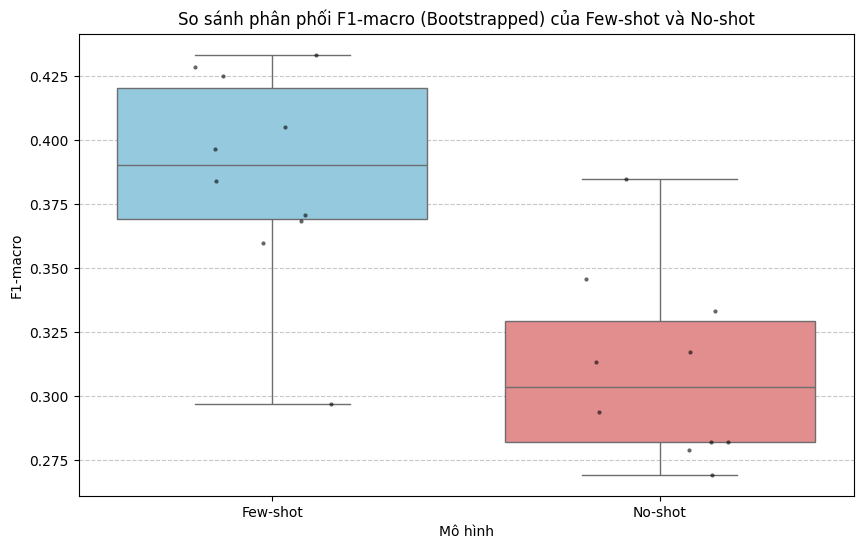

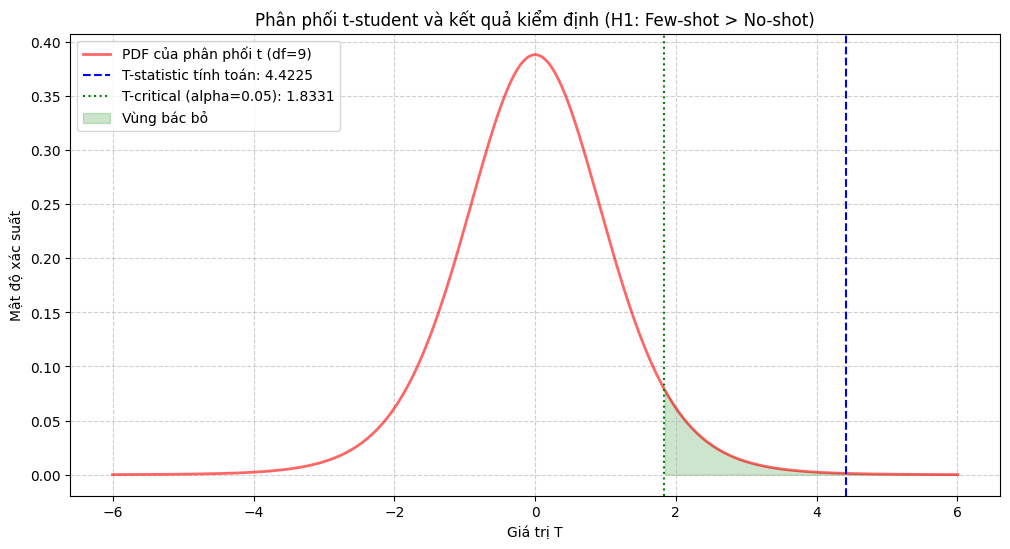

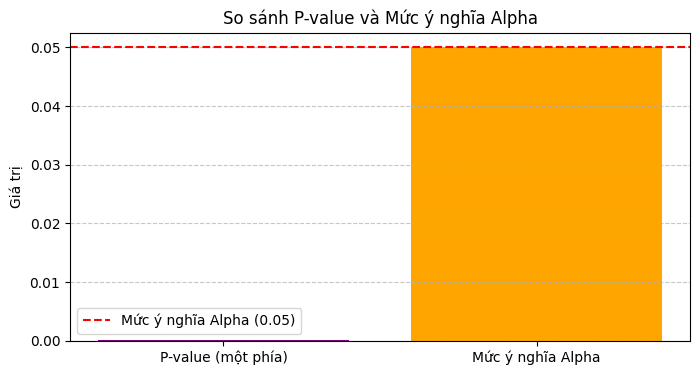


K·∫øt qu·∫£ T-test:
  Th·ªëng k√™ T: 4.4225
  Gi√° tr·ªã P (m·ªôt ph√≠a): 0.0002
  K·∫øt lu·∫≠n: B√°c b·ªè H0. Few-shot t·ªët h∆°n No-shot m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p=0.000169834).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3852478751.py:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot,


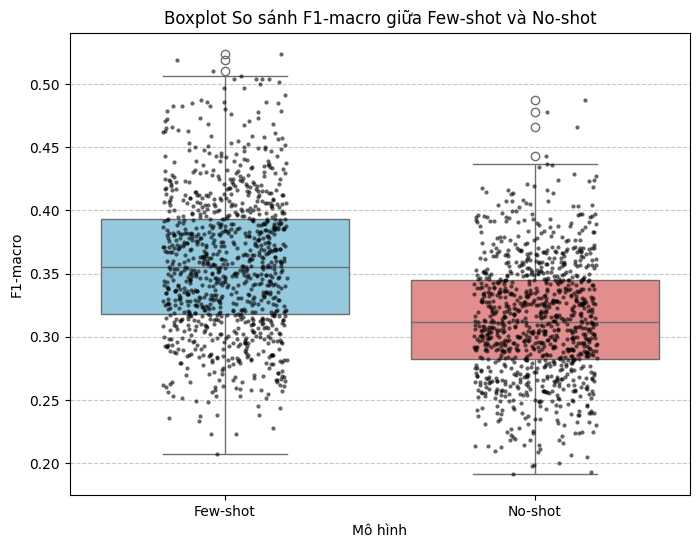

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # ttest_ind for independent samples
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# C·∫•u h√¨nh logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- C√°c h√†m h·ªó tr·ª£ c·∫ßn thi·∫øt cho vi·ªác l·∫•y nh√£n v√† t√≠nh to√°n ---

def extract_bloom_level(label_string: str) -> str:
    """
    Tr√≠ch xu·∫•t c·∫•p ƒë·ªô Bloom ch√≠nh t·ª´ chu·ªói nh√£n c√≥ th·ªÉ ch·ª©a m√¥ t·∫£.
    V√≠ d·ª•: "Remember (Ghi nh·ªõ): Nh·ªõ l·∫°i th√¥ng tin c∆° b·∫£n..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    T·∫£i d·ªØ li·ªáu ƒë√£ g·∫Øn nh√£n c·ªßa ng∆∞·ªùi v√† m√°y, sau ƒë√≥ so s√°nh c√°c nh√£n Bloom.
    H√†m n√†y ƒë∆∞·ª£c t·ªëi ∆∞u ƒë·ªÉ ch·ªâ tr·∫£ v·ªÅ true_labels v√† predicted_labels cho c√°c ki·ªÉm ƒë·ªãnh th·ªëng k√™,
    kh√¥ng in ra c√°c ma tr·∫≠n hay b√°o c√°o chi ti·∫øt kh√°c.

    Args:
        human_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do ng∆∞·ªùi g·∫Øn nh√£n.
                                   H·ªó tr·ª£ CSV.
        llm_labeled_path (str): ƒê∆∞·ªùng d·∫´n ƒë·∫øn file ch·ª©a d·ªØ li·ªáu do LLM g·∫Øn nh√£n.
                                  H·ªó tr·ª£ CSV ho·∫∑c JSON.
        id_column (str): T√™n c·ªôt ch·ª©a ID duy nh·∫•t c·ªßa m·ªói m·ª•c.
        human_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa ng∆∞·ªùi.
        llm_bloom_label_column (str): T√™n c·ªôt ch·ª©a nh√£n Bloom trong file c·ªßa m√°y.

    Returns:
        Optional[Dict[str, Any]]: M·ªôt dictionary ch·ª©a true_labels v√† predicted_labels,
                                  ho·∫∑c None n·∫øu c√≥ l·ªói.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi t·∫°i '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa ng∆∞·ªùi ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa ng∆∞·ªùi '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"L·ªói: ƒê·ªãnh d·∫°ng file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£. Ch·ªâ ch·∫•p nh·∫≠n .csv ho·∫∑c .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"L·ªói: Kh√¥ng t√¨m th·∫•y file d·ªØ li·ªáu c·ªßa m√°y t·∫°i '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"L·ªói: File d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}' ph·∫£i c√≥ c·ªôt '{id_column}' v√† '{llm_bloom_label_column}' v√† ƒë·ªãnh d·∫°ng h·ª£p l·ªá: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"L·ªói khi t·∫£i file d·ªØ li·ªáu c·ªßa m√°y '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"M·ª•c '{item_id}': Nh√£n Bloom r·ªóng ho·∫∑c kh√¥ng h·ª£p l·ªá sau khi tr√≠ch xu·∫•t. B·ªè qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"M·ª•c '{item_id}' kh√¥ng c√≥ c·ªôt nh√£n Bloom c·∫ßn thi·∫øt ({e}). B·ªè qua.")
                continue
            except Exception as e:
                logger.warning(f"L·ªói x·ª≠ l√Ω m·ª•c '{item_id}': {e}. B·ªè qua.")
                continue

    if common_items_count == 0:
        logger.warning("Kh√¥ng t√¨m th·∫•y m·ª•c chung n√†o gi·ªØa hai t·∫≠p d·ªØ li·ªáu ho·∫∑c kh√¥ng c√≥ nh√£n. Kh√¥ng th·ªÉ t√≠nh c√°c metric ƒë·ªìng thu·∫≠n nh√£n Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    T·∫°o ra ph√¢n ph·ªëi F1-score b·∫±ng ph∆∞∆°ng ph√°p bootstrapping.

    Args:
        true_labels (List[str]): Danh s√°ch nh√£n th·ª±c t·∫ø.
        predicted_labels (List[str]): Danh s√°ch nh√£n d·ª± ƒëo√°n.
        n_bootstraps (int): S·ªë l·∫ßn l·∫•y m·∫´u l·∫°i.

    Returns:
        List[float]: Danh s√°ch c√°c F1-score t·ªïng th·ªÉ (macro avg) t·ª´ c√°c m·∫´u l·∫°i.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh s√°ch nh√£n th·ª±c t·∫ø v√† d·ª± ƒëo√°n ph·∫£i c√≥ c√πng ƒë·ªô d√†i.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # ƒê·∫£m b·∫£o c√°c nh√£n kh·ªõp v·ªõi c√°c nh√£n c√≥ th·ªÉ c√≥ trong d·ªØ li·ªáu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # L·∫•y m·∫´u l·∫°i c√°c ch·ªâ s·ªë v·ªõi thay th·∫ø
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # T·∫°o c√°c m·∫´u l·∫°i c·ªßa nh√£n
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # T√≠nh F1-score cho m·∫´u l·∫°i
        # S·ª≠ d·ª•ng zero_division=0 ƒë·ªÉ tr√°nh l·ªói khi m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong m·∫´u l·∫°i
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # L·∫•y F1-score t·ªïng th·ªÉ (macro avg)
        overall_f1 = report['macro avg']['f1-score'] # L·∫•y F1-macro
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Th·ª±c hi·ªán ki·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a cho hai m·∫´u ƒë·ªôc l·∫≠p v√† v·∫Ω bi·ªÉu ƒë·ªì so s√°nh.

    Args:
        scores1 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© nh·∫•t.
        scores2 (List[float]): Danh s√°ch ƒëi·ªÉm s·ªë cho nh√≥m th·ª© hai.
        scores1_name (str): T√™n c·ªßa nh√≥m th·ª© nh·∫•t (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        scores2_name (str): T√™n c·ªßa nh√≥m th·ª© hai (ƒë·ªÉ hi·ªÉn th·ªã tr√™n bi·ªÉu ƒë·ªì).
        alpha (float): M·ª©c √Ω nghƒ©a (significance level).
        hypothesis (str): "greater" n·∫øu scores1 > scores2, "less" n·∫øu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary ch·ª©a th·ªëng k√™ t, gi√° tr·ªã p, v√† k·∫øt lu·∫≠n.
    """
    if not scores1 or not scores2:
        logger.warning("Kh√¥ng ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß d·ªØ li·ªáu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("C·∫ßn √≠t nh·∫•t 2 m·∫´u trong m·ªói nh√≥m ƒë·ªÉ th·ª±c hi·ªán T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Kh√¥ng ƒë·ªß m·∫´u ƒë·ªÉ th·ª±c hi·ªán T-test."}

    # S·ª≠ d·ª•ng ttest_ind v√¨ ƒë√¢y l√† c√°c m·∫´u ƒë·ªôc l·∫≠p (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Lu√¥n t√≠nh p-value m·ªôt ph√≠a

    print(f"\nKi·ªÉm ƒë·ªãnh T-test m·ªôt ph√≠a (H1: {scores1_name} t·ªët h∆°n {scores2_name}):")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m {scores1_name}: {mean1:.4f}")
    print(f"  Gi√° tr·ªã trung b√¨nh F1-macro nh√≥m {scores2_name}: {mean2:.4f}")
    print(f"  Th·ªëng k√™ T: {t_statistic:.4f}")
    print(f"  Gi√° tr·ªã P (hai ph√≠a): {p_value_two_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {p_value_one_tailed:.9f}") # In 9 ch·ªØ s·ªë sau d·∫•u ph·∫©y
    print(f"  M·ª©c √Ω nghƒ©a alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"B√°c b·ªè H0. {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng ƒë·ªÉ b√°c b·ªè H0. Kh√¥ng c√≥ b·∫±ng ch·ª©ng {scores1_name} t·ªët h∆°n {scores2_name} m·ªôt c√°ch c√≥ √Ω nghƒ©a th·ªëng k√™ (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Ki·ªÉm ƒë·ªãnh kh√¥ng ph√π h·ª£p v·ªõi gi·∫£ thuy·∫øt 'greater'."

    # --- V·∫Ω bi·ªÉu ƒë·ªì h·ªôp so s√°nh ph√¢n ph·ªëi ƒëi·ªÉm s·ªë ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'M√¥ h√¨nh': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-macro': scores1 + scores2
    })
    sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='M√¥ h√¨nh', y='F1-macro', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Th√™m c√°c ƒëi·ªÉm d·ªØ li·ªáu
    plt.title(f'So s√°nh ph√¢n ph·ªëi F1-macro (Bootstrapped) c·ªßa {scores1_name} v√† {scores2_name}')
    plt.ylabel('F1-macro')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF c·ªßa ph√¢n ph·ªëi t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic t√≠nh to√°n: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='V√πng b√°c b·ªè')

    plt.title(f'Ph√¢n ph·ªëi t-student v√† k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Gi√° tr·ªã T')
    plt.ylabel('M·∫≠t ƒë·ªô x√°c su·∫•t')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- V·∫Ω bi·ªÉu ƒë·ªì so s√°nh P-value v√† Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (m·ªôt ph√≠a)', 'M·ª©c √Ω nghƒ©a Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'M·ª©c √Ω nghƒ©a Alpha ({alpha})')
    plt.title('So s√°nh P-value v√† M·ª©c √Ω nghƒ©a Alpha')
    plt.ylabel('Gi√° tr·ªã')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- L·∫•y nh√£n t·ª´ c√°c file few-shot v√† no-shot ---
logger.info("\n========== L·∫•y nh√£n ƒë·ªÉ th·ª±c hi·ªán T-test (F1-macro) ==========")

# L·∫•y nh√£n cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# L·∫•y nh√£n cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Th·ª±c hi·ªán T-test so s√°nh Few-Shot v√† No-Shot ---
logger.info("\n========== Th·ª±c hi·ªán Ki·ªÉm ƒë·ªãnh T-test so s√°nh F1-macro c·ªßa Few-Shot v√† No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    # T·∫°o ph√¢n ph·ªëi F1-macro b·∫±ng bootstrapping
    f1_scores_distribution_no_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels'],
        n_bootstraps=10 # ƒê·∫∑t s·ªë l·∫ßn bootstrap l√† 10
    )
    f1_scores_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # ƒê·∫∑t s·ªë l·∫ßn bootstrap l√† 10
    )

    # ƒê·∫£m b·∫£o c√≥ ƒë·ªß d·ªØ li·ªáu t·ª´ bootstrapping
    if not f1_scores_distribution_no_shot_macro or not f1_scores_distribution_few_shot_macro:
        logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu F1-macro t·ª´ bootstrapping ƒë·ªÉ th·ª±c hi·ªán T-test.")
    else:
        # Th·ª±c hi·ªán T-test m·ªôt ph√≠a (H1: few-shot t·ªët h∆°n no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=f1_scores_distribution_few_shot_macro, # Nh√≥m 1: Few-shot
            scores2=f1_scores_distribution_no_shot_macro,  # Nh√≥m 2: No-shot
            scores1_name="Few-shot", # T√™n cho bi·ªÉu ƒë·ªì
            scores2_name="No-shot",  # T√™n cho bi·ªÉu ƒë·ªì
            hypothesis="greater" # Gi·∫£ thuy·∫øt: Few-shot t·ªët h∆°n No-shot
        )
        print(f"\nK·∫øt qu·∫£ T-test:")
        print(f"  Th·ªëng k√™ T: {t_test_results['t_statistic']:.4f}")
        print(f"  Gi√° tr·ªã P (m·ªôt ph√≠a): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  K·∫øt lu·∫≠n: {t_test_results['conclusion']}")
else:
    logger.error("Kh√¥ng ƒë·ªß k·∫øt qu·∫£ ƒë√°nh gi√° nh√£n Bloom t·ª´ c·∫£ hai m√¥ h√¨nh ƒë·ªÉ th·ª±c hi·ªán T-test.")

# --- Bi·ªÉu ƒë·ªì Boxplot t·ªïng h·ª£p (ch·ªâ bao g·ªìm Few-shot v√† No-shot) ---
if bloom_labels_no_shot and bloom_labels_few_shot:
    f1_scores_distribution_no_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels'],
        n_bootstraps=1000
    )
    f1_scores_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=1000
    )

    if f1_scores_distribution_few_shot_macro and f1_scores_distribution_no_shot_macro:
        plt.figure(figsize=(8, 6))
        
        data_for_boxplot = pd.DataFrame({
            'M√¥ h√¨nh': ['Few-shot'] * len(f1_scores_distribution_few_shot_macro) +
                       ['No-shot'] * len(f1_scores_distribution_no_shot_macro),
            'F1-macro': f1_scores_distribution_few_shot_macro + f1_scores_distribution_no_shot_macro
        })

        sns.boxplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot, 
                    palette={'Few-shot': 'skyblue', 'No-shot': 'lightcoral'})
        sns.stripplot(x='M√¥ h√¨nh', y='F1-macro', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
        
        plt.title("Boxplot So s√°nh F1-macro gi·ªØa Few-shot v√† No-shot")
        plt.ylabel("F1-macro")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        logger.error("Kh√¥ng ƒë·ªß d·ªØ li·ªáu F1-macro ƒë·ªÉ v·∫Ω Boxplot t·ªïng h·ª£p.")
